In [1]:
import pickle
import abc
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
import datetime
import seaborn as sn
import pandas as pd
import numpy as np
import time
import itertools

In [2]:
tf.random.set_seed(1234)

In [3]:
%load_ext tensorboard

### Data preprocessing


In [4]:
# Wczytanie zbioru danych
dataset_path = '../mlp-98c-kornelro/dataset.pkl'

with open(dataset_path, 'rb') as f:
    dataset = pickle.load(f)
    
def get_preprocessed_data(subset_type, batch_size=None):

    images = dataset[subset_type]['X']
    labels = dataset[subset_type]['y']

    # Zmiana rozmiaru obrazu z 224x224 do 64x64
    images = tf.image.resize(
        images, [64, 64], 
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR, 
        preserve_aspect_ratio=False,
        name=None
    )

    # Zmiana typu obrazów z int na float i normalizacja wartości pikseli z przedziału 0-255 do przedziału 0-1
    images = tf.cast(images, tf.float32) / 255.0
        
    # Zmiana wymiarowości z [8870] na [8870, 1] w celu zastosowania `SparseCategoricalCrossentropy`
    labels = tf.reshape(labels, [-1, 1])

    # Do iterowania zbioru danych i podzielenia na paczki (ang. batch) można wykorzystać interfejs zdefiniowany w `tensorflow.data.Dataset`
    if batch_size:
        ds = tf.data.Dataset.from_tensor_slices((images, labels))
        ds = ds.shuffle(buffer_size=len(images)).batch(batch_size=batch_size)
    else:
        ds = {'X': images, 'y': labels}

    return ds

val_ds = get_preprocessed_data('validation')
test_ds = get_preprocessed_data('test')

### Base classes

In [5]:
class AbstractLayer(tf.keras.layers.Layer):
    """Abstract Layer."""
    
    def __init__(self):
        """Inits the class."""
        super(AbstractLayer, self).__init__()
    
    @abc.abstractmethod
    def call(self, inputs):
        """Makes forward pass of the layer."""
        pass


class AbstractModel(tf.keras.Model):
    """Abstract model."""

    def __init__(self):
        """Inits the class."""
        super(AbstractModel, self).__init__()

    @abc.abstractmethod
    def call(self, inputs, training=False):
        """Makes forward pass of the network."""
        pass

    @abc.abstractmethod
    def fit(self, **kwargs):
        """Fits the model.

        Replaces original fit method.
        
        More information can be found in documentation:
        https://www.tensorflow.org/guide/eager
        https://www.tensorflow.org/guide/autodiff
        """
        pass

    @abc.abstractmethod
    def predict(self, x):
        """Predicts x"""
        pass

### Implementations

In [6]:
class FullyConnected(AbstractLayer):

    def __init__(self, input_shape, units, initilizer='random_uniform'):
        super(FullyConnected, self).__init__()
        #initializer = 

        self.w = self.add_weight(
            shape=([input_shape[-1], units]),
            initializer='random_uniform',
            trainable=True
        )
        self.b = self.add_weight(
            shape=([units]),
            initializer='random_uniform',
            trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

In [7]:
class Model(AbstractModel):

    def __init__(self, w_initilizer):
        super(Model, self).__init__()
        self.fc1 = FullyConnected([1, 12288], 256, w_initilizer)
        self.act1 = tf.keras.activations.relu
        self.fc2 = FullyConnected([1, 256], 14, w_initilizer)
        self.act2 = tf.keras.activations.softmax
        
        self.layers_num = 2
        self.logs_df = None            

    def call(self, inputs, training=False):
        inputs = tf.reshape(inputs, [-1, 64*64*3])
        X = self.fc1(inputs)
        X = self.act1(X)
        X = self.fc2(X)
        X = self.act2(X)

        return X 
    
    def _acc(self, y_true, y_pred_probs):
        y_true = tf.reshape(y_true, y_true.shape[0])
        y_pred = tf.math.argmax(y_pred_probs, 1)
        y_pred = tf.reshape(y_pred, y_pred.shape[0])
    
        return accuracy_score(y_true, y_pred)

    def fit(self, train_ds, val_ds, epochs,
            loss_fn, eval_fn, optimizer,
            verbose = True,
            logs_params=None
    ):
        
        if not logs_params:
            current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
            train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
            train_summary_writer = tf.summary.create_file_writer(train_log_dir)
            val_log_dir = 'logs/gradient_tape/' + current_time + '/validation'
            val_summary_writer = tf.summary.create_file_writer(val_log_dir)

        train_loss_m = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
        train_f1_m = tf.keras.metrics.Mean('train_f1', dtype=tf.float32)
        train_acc_m = tf.keras.metrics.Mean('train_acc', dtype=tf.float32)

        tqdm_disable = not verbose
        for epoch in range(epochs):
            start_time = time.time()
            for x_batch, y_batch in tqdm(train_ds, disable=tqdm_disable):
                with tf.GradientTape() as tape:
                    probs = self.call(x_batch)
                    loss = loss_fn(y_batch, probs)
                    train_loss_m(loss)
                    f1 = eval_fn(y_batch, probs)
                    train_f1_m(f1)
                    acc = self._acc(y_batch, probs)
                    train_acc_m(acc)
                grads = tape.gradient(loss, self.trainable_weights)
                optimizer.apply_gradients(zip(grads, self.trainable_weights))
                
            train_loss = train_loss_m.result()
            train_f1 = train_f1_m.result()
            train_acc = train_acc_m.result()
            if not logs_params:
                with train_summary_writer.as_default():
                    tf.summary.scalar('train_loss', train_loss, step=epoch+1)
                    tf.summary.scalar('train_f1', train_f1, step=epoch+1)
                    tf.summary.scalar('train_acc', train_acc, step=epoch+1)
            train_loss_m.reset_states()
            train_f1_m.reset_states()
            train_acc_m.reset_states()

            val_probs = self.call(val_ds['X'])
            val_loss = loss_fn(val_ds['y'], val_probs)
            val_f1 = eval_fn(val_ds['y'], val_probs)
            val_acc = self._acc(val_ds['y'], val_probs)
            if not logs_params:
                with val_summary_writer.as_default():
                    tf.summary.scalar('val_loss', val_loss, step=epoch+1)
                    tf.summary.scalar('val_f1', val_f1, step=epoch+1)
                    tf.summary.scalar('val_acc', val_acc, step=epoch+1)
             
            if verbose:
                template = 'Epoch {}, Train Loss: {}, Train F1: {}, Val Loss: {}, Val F1: {}'
                print (template.format(epoch+1, train_loss, train_f1, val_loss, val_f1))
            
            if logs_params:
                if self.logs_df is None:
                    self.logs_df = pd.DataFrame(columns=list(logs_params.keys()).extend(
                        ['train_loss', 'train_f1', 'test_loss', 'test_f1',
                         'train_acc', 'test_acc', 'time_s', 'epoch_num']
                    ))
                logs_params['train_loss'] = round(train_loss.numpy(), 4)
                logs_params['train_f1'] = round(train_f1.numpy(), 4)
                logs_params['train_acc'] = round(train_acc.numpy(), 4)
                logs_params['val_loss'] = round(val_loss.numpy(), 4)
                logs_params['val_f1'] = round(val_f1, 4)
                logs_params['val_acc'] = round(val_acc, 4)
                logs_params['time_s']= round(time.time() - start_time, 2)
                logs_params['epoch_num'] = epoch + 1
                self.logs_df = self.logs_df.append(logs_params, ignore_index=True)

### Helper functions to run experiments

In [8]:
def f1_eval(y_true, y_pred_probs):
    y_true = tf.reshape(y_true, y_true.shape[0])
    y_pred = tf.math.argmax(y_pred_probs, 1)
    y_pred = tf.reshape(y_pred, y_pred.shape[0])
    
    return f1_score(y_true, y_pred, average='macro')

In [9]:
def run_experiment(model=Model,
                   initialization='random_uniform',
                   optimizer='Adam',
                   lr=0.001,
                   epochs=25,
                   batch=100
                  ):
    
    train_ds = get_preprocessed_data('train', batch)
    model = model(initialization)
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
    eval_fn = f1_eval
    
    logs_params = {
        'layers': model.layers_num,
        'initialization': initialization,
        'optimizer': optimizer,
        'lr': lr,
        'epochs': epochs,
        'batch': batch
    }
    
    optimizer = tf.keras.optimizers.Adam(lr) if model == 'Adam' else tf.keras.optimizers.SGD(lr)
    
    model.fit(train_ds, val_ds, epochs, loss_fn, eval_fn, optimizer, True, logs_params)
    
    return model, logs_params

In [10]:
def run_experiments(params):
    
    results_df = None
    results = []
    
    keys = list(params)
    for values in itertools.product(*map(params.get, keys)):
        
        model, logs_params = run_experiment(**dict(zip(keys, values)))
    
        next_row = model.logs_df[model.logs_df['val_f1'] == model.logs_df['val_f1'].max()].iloc[0]
        next_row['total_time_s'] = model.logs_df['time_s'].sum()
        if results_df is None:
            results_df = next_row.to_frame().T
        else:
            results_df = results_df.append(next_row, ignore_index=True)
        results.append({
            'model': model,
            'logs_params': logs_params
        })
        
    return results_df, results

In [11]:
def print_results(model, logs_params):
    if model.logs_df is None:
        print('No logs DataFrame!')
    else:
        print('--MODEL--')
        print('Layers: ', logs_params['layers'])
        print('Initialization: ', logs_params['initialization'])
        print('Optimizer: ', logs_params['optimizer'])
        print('Learning rate: ', logs_params['lr'])
        print('Epochs: ', logs_params['epochs'])
        print('Batch: ', logs_params['batch'])
        print()
        print('Best validation F1Score: ', model.logs_df['val_f1'].max())
        print('Best validation Loss: ', model.logs_df['val_loss'].min())
        print('Best validation Accuracy: ', model.logs_df['val_acc'].max())
        print()
        print('Mean epoch time (s): ', round(model.logs_df['time_s'].mean(), 2))
        print('Total time (s): ', round(model.logs_df['time_s'].sum(), 2))

In [12]:
def plot_results(model):
    if model.logs_df is None:
        print('No logs DataFrame!')
    else:
        epochs = [i+1 for i in range(len(model.logs_df['train_loss']))]
        fig, axs = plt.subplots(1, 3, figsize=(20,5))
        axs[0].plot(epochs, model.logs_df['train_loss'], label='TRAIN')
        axs[0].plot(epochs, model.logs_df['val_loss'], label='VALIDATION')
        axs[0].legend()
        axs[0].title.set_text('LOSS')
        axs[0].set_xlabel('EPOCH')
        axs[0].set_ylabel('VALUE')
        axs[1].plot(epochs, model.logs_df['train_f1'], label='TRAIN')
        axs[1].plot(epochs, model.logs_df['val_f1'], label='VALIDATION')
        axs[1].legend()
        axs[1].title.set_text('F1 SCORE')
        axs[1].set_xlabel('EPOCH')
        axs[1].set_ylabel('VALUE')
        axs[2].plot(epochs, model.logs_df['train_acc'], label='TRAIN')
        axs[2].plot(epochs, model.logs_df['val_acc'], label='VALIDATION')
        axs[2].legend()
        axs[2].title.set_text('ACCURACY')
        axs[2].set_xlabel('EPOCH')
        axs[2].set_ylabel('VALUE')
        plt.show()
        print()

In [13]:
def show_experiments_results(results):
    for result in results:
        print_results(result['model'], result['logs_params'])
        plot_results(result['model'])

### Task 1 - initialization method, layers number

In [14]:
Model_2_layers = Model

class Model_3_layers(Model):

    def __init__(self, w_initilizer):
        super(Model, self).__init__()
        self.fc1 = FullyConnected([1, 12288], 6000, w_initilizer)
        self.act1 = tf.keras.activations.relu
        self.fc2 = FullyConnected([1, 6000], 256, w_initilizer)
        self.act2 = tf.keras.activations.relu
        self.fc3 = FullyConnected([1, 256], 14, w_initilizer)
        self.act3 = tf.keras.activations.softmax
        
        self.layers_num = 3
        self.logs_df = None 

    def call(self, inputs, training=False):
        inputs = tf.reshape(inputs, [-1, 64*64*3])
        X = self.fc1(inputs)
        X = self.act1(X)
        X = self.fc2(X)
        X = self.act2(X)
        X = self.fc3(X)
        X = self.act3(X)

        return X 

In [15]:
params = {
    'model': [Model_2_layers, Model_3_layers],
    'initialization': ['random_uniform', 'random_normal'],
    'optimizer': ['Adam'],
    'lr': [0.001],
    'epochs': [25],
    'batch': [100]
}

results_df_1, results_1 = run_experiments(params)

  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 1, Train Loss: 2.5898873805999756, Train F1: 0.036210011690855026, Val Loss: 2.561654806137085, Val F1: 0.038861201654716716


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 2, Train Loss: 2.555039167404175, Train F1: 0.037375371903181076, Val Loss: 2.5459866523742676, Val F1: 0.03743216129736265


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 3, Train Loss: 2.5384693145751953, Train F1: 0.0376955084502697, Val Loss: 2.532977342605591, Val F1: 0.03987932455433737


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 4, Train Loss: 2.5242693424224854, Train F1: 0.038614463061094284, Val Loss: 2.521458148956299, Val F1: 0.04207428699489656


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 5, Train Loss: 2.5117037296295166, Train F1: 0.04154093563556671, Val Loss: 2.511542558670044, Val F1: 0.04358244790663734


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 6, Train Loss: 2.500675916671753, Train F1: 0.04297848045825958, Val Loss: 2.50239634513855, Val F1: 0.04734098777777746


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 7, Train Loss: 2.4912326335906982, Train F1: 0.04599427804350853, Val Loss: 2.4947214126586914, Val F1: 0.054855010609159524


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 8, Train Loss: 2.4821739196777344, Train F1: 0.05050143599510193, Val Loss: 2.487962007522583, Val F1: 0.05324575802346925


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 9, Train Loss: 2.4737722873687744, Train F1: 0.05333171784877777, Val Loss: 2.4820799827575684, Val F1: 0.0690806834190867


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 10, Train Loss: 2.4659690856933594, Train F1: 0.05995168164372444, Val Loss: 2.475966215133667, Val F1: 0.0703664130607535


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 11, Train Loss: 2.4579930305480957, Train F1: 0.06373821943998337, Val Loss: 2.4700119495391846, Val F1: 0.06065758938078414


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 12, Train Loss: 2.451786994934082, Train F1: 0.06541670858860016, Val Loss: 2.4644904136657715, Val F1: 0.0752350162600554


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 13, Train Loss: 2.4458770751953125, Train F1: 0.07071404159069061, Val Loss: 2.458815813064575, Val F1: 0.08027301810486025


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 14, Train Loss: 2.438615322113037, Train F1: 0.07568339258432388, Val Loss: 2.454651355743408, Val F1: 0.08379239646910576


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 15, Train Loss: 2.433182716369629, Train F1: 0.08257153630256653, Val Loss: 2.450286865234375, Val F1: 0.08420455705105866


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 16, Train Loss: 2.427450656890869, Train F1: 0.08661136031150818, Val Loss: 2.446014642715454, Val F1: 0.08981796881108309


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 17, Train Loss: 2.4227709770202637, Train F1: 0.09052697569131851, Val Loss: 2.4420325756073, Val F1: 0.0916045191355493


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 18, Train Loss: 2.4179739952087402, Train F1: 0.09272969514131546, Val Loss: 2.438710927963257, Val F1: 0.08999620543003552


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 19, Train Loss: 2.4129300117492676, Train F1: 0.09637410193681717, Val Loss: 2.4360899925231934, Val F1: 0.10711158199865224


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 20, Train Loss: 2.407564401626587, Train F1: 0.09971912205219269, Val Loss: 2.4310295581817627, Val F1: 0.09320085133736522


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 21, Train Loss: 2.4037904739379883, Train F1: 0.09860508143901825, Val Loss: 2.427910566329956, Val F1: 0.0968603514332678


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 22, Train Loss: 2.3989627361297607, Train F1: 0.10422785580158234, Val Loss: 2.4259753227233887, Val F1: 0.10128412646007681


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 23, Train Loss: 2.3953659534454346, Train F1: 0.10667673498392105, Val Loss: 2.4229233264923096, Val F1: 0.09456880161400583


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 24, Train Loss: 2.3918795585632324, Train F1: 0.10418656468391418, Val Loss: 2.4200947284698486, Val F1: 0.11022745702960046


100%|██████████| 89/89 [00:02<00:00, 33.48it/s]


Epoch 25, Train Loss: 2.3873748779296875, Train F1: 0.113299660384655, Val Loss: 2.4169816970825195, Val F1: 0.10001898596092564


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 1, Train Loss: 2.613240957260132, Train F1: 0.028972957283258438, Val Loss: 2.561267852783203, Val F1: 0.03461875817774835


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 2, Train Loss: 2.558603286743164, Train F1: 0.03166423365473747, Val Loss: 2.5479514598846436, Val F1: 0.035347748704048436


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 3, Train Loss: 2.5440714359283447, Train F1: 0.032570309937000275, Val Loss: 2.536807060241699, Val F1: 0.034257508473793837


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 4, Train Loss: 2.5318870544433594, Train F1: 0.03327470272779465, Val Loss: 2.5262362957000732, Val F1: 0.03605359665576709


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 5, Train Loss: 2.521078586578369, Train F1: 0.034292541444301605, Val Loss: 2.518556594848633, Val F1: 0.04021088435684755


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 6, Train Loss: 2.5103883743286133, Train F1: 0.038009162992239, Val Loss: 2.509552478790283, Val F1: 0.040864662838772596


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 7, Train Loss: 2.5014240741729736, Train F1: 0.0406135693192482, Val Loss: 2.502321243286133, Val F1: 0.047002433998736985


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 8, Train Loss: 2.49289870262146, Train F1: 0.04386715963482857, Val Loss: 2.495107412338257, Val F1: 0.04735003175493963


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 9, Train Loss: 2.4841983318328857, Train F1: 0.04677995294332504, Val Loss: 2.489065170288086, Val F1: 0.04924796145670601


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 10, Train Loss: 2.4769227504730225, Train F1: 0.05260146036744118, Val Loss: 2.4830617904663086, Val F1: 0.05738572716363644


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 11, Train Loss: 2.469310760498047, Train F1: 0.059834957122802734, Val Loss: 2.4779860973358154, Val F1: 0.05344257872922405


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 12, Train Loss: 2.462986707687378, Train F1: 0.05970165133476257, Val Loss: 2.4719812870025635, Val F1: 0.06362151496883658


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 13, Train Loss: 2.456108808517456, Train F1: 0.06542560458183289, Val Loss: 2.467412233352661, Val F1: 0.0656565191355787


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 14, Train Loss: 2.449671506881714, Train F1: 0.07093702256679535, Val Loss: 2.4624924659729004, Val F1: 0.06666577278422502


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 15, Train Loss: 2.444448947906494, Train F1: 0.07652810215950012, Val Loss: 2.4583656787872314, Val F1: 0.0720466837041149


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 16, Train Loss: 2.438772678375244, Train F1: 0.0783042162656784, Val Loss: 2.4545481204986572, Val F1: 0.07705995498039216


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 17, Train Loss: 2.4330246448516846, Train F1: 0.08508070558309555, Val Loss: 2.4505887031555176, Val F1: 0.07597122706036187


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 18, Train Loss: 2.4286134243011475, Train F1: 0.08801791071891785, Val Loss: 2.4465034008026123, Val F1: 0.08592598276492089


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 19, Train Loss: 2.423496961593628, Train F1: 0.09081891179084778, Val Loss: 2.444504976272583, Val F1: 0.08043560643539027


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 20, Train Loss: 2.4183287620544434, Train F1: 0.08954516053199768, Val Loss: 2.44044828414917, Val F1: 0.09236484735998081


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 21, Train Loss: 2.4139156341552734, Train F1: 0.0953151285648346, Val Loss: 2.436591386795044, Val F1: 0.09006660971489945


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 22, Train Loss: 2.4095499515533447, Train F1: 0.0959826186299324, Val Loss: 2.4343345165252686, Val F1: 0.09203119610379908


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 23, Train Loss: 2.406043291091919, Train F1: 0.09707693755626678, Val Loss: 2.431356191635132, Val F1: 0.10075350847652419


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 24, Train Loss: 2.4026334285736084, Train F1: 0.10120749473571777, Val Loss: 2.428178071975708, Val F1: 0.09634158363800516


100%|██████████| 89/89 [00:02<00:00, 35.65it/s]


Epoch 25, Train Loss: 2.3984580039978027, Train F1: 0.10317139327526093, Val Loss: 2.4261014461517334, Val F1: 0.09569229912783493


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 1, Train Loss: 2.5918619632720947, Train F1: 0.04221821203827858, Val Loss: 2.552751064300537, Val F1: 0.06317559572459473


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 2, Train Loss: 2.5242130756378174, Train F1: 0.05592859908938408, Val Loss: 2.518198013305664, Val F1: 0.062015329517763264


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 3, Train Loss: 2.4891164302825928, Train F1: 0.07204211503267288, Val Loss: 2.49284291267395, Val F1: 0.07107082580404


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 4, Train Loss: 2.4615256786346436, Train F1: 0.08825186640024185, Val Loss: 2.4736266136169434, Val F1: 0.09560825822710277


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 5, Train Loss: 2.4390642642974854, Train F1: 0.09811434894800186, Val Loss: 2.4609711170196533, Val F1: 0.08221116342509922


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 6, Train Loss: 2.421001434326172, Train F1: 0.10371115058660507, Val Loss: 2.448153018951416, Val F1: 0.09273566598738048


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 7, Train Loss: 2.404414653778076, Train F1: 0.11290454864501953, Val Loss: 2.435725688934326, Val F1: 0.09597095611870173


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 8, Train Loss: 2.390589952468872, Train F1: 0.11608262360095978, Val Loss: 2.424546957015991, Val F1: 0.11108573914484267


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 9, Train Loss: 2.376284599304199, Train F1: 0.12188880145549774, Val Loss: 2.418433427810669, Val F1: 0.11440661696326362


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 10, Train Loss: 2.3646652698516846, Train F1: 0.1294146627187729, Val Loss: 2.411306142807007, Val F1: 0.12069029316985448


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 11, Train Loss: 2.3534417152404785, Train F1: 0.13214439153671265, Val Loss: 2.40392804145813, Val F1: 0.12055976027378422


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 12, Train Loss: 2.3407394886016846, Train F1: 0.13827571272850037, Val Loss: 2.401562213897705, Val F1: 0.1197482611658519


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 13, Train Loss: 2.3319602012634277, Train F1: 0.13963712751865387, Val Loss: 2.3922529220581055, Val F1: 0.12406810371181387


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 14, Train Loss: 2.321240186691284, Train F1: 0.1417408585548401, Val Loss: 2.3899459838867188, Val F1: 0.12528361917259215


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 15, Train Loss: 2.3131368160247803, Train F1: 0.1497417837381363, Val Loss: 2.3807690143585205, Val F1: 0.14357144956136847


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 16, Train Loss: 2.3039395809173584, Train F1: 0.15427051484584808, Val Loss: 2.3777620792388916, Val F1: 0.1356513203519178


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 17, Train Loss: 2.294175863265991, Train F1: 0.15380926430225372, Val Loss: 2.374387741088867, Val F1: 0.13777220928383377


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 18, Train Loss: 2.2861382961273193, Train F1: 0.1546778827905655, Val Loss: 2.3706185817718506, Val F1: 0.1308045396130602


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 19, Train Loss: 2.277599334716797, Train F1: 0.1561848372220993, Val Loss: 2.368607521057129, Val F1: 0.1473598739828937


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 20, Train Loss: 2.2706172466278076, Train F1: 0.16496367752552032, Val Loss: 2.365266799926758, Val F1: 0.14461356742569137


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 21, Train Loss: 2.2634732723236084, Train F1: 0.16866306960582733, Val Loss: 2.3622887134552, Val F1: 0.16158781408594206


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 22, Train Loss: 2.256009340286255, Train F1: 0.1706332564353943, Val Loss: 2.3569018840789795, Val F1: 0.16567434393503944


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 23, Train Loss: 2.2495920658111572, Train F1: 0.1731444001197815, Val Loss: 2.3539390563964844, Val F1: 0.15054985521422454


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 24, Train Loss: 2.2419071197509766, Train F1: 0.18137571215629578, Val Loss: 2.3482401371002197, Val F1: 0.15288754327725468


100%|██████████| 89/89 [00:31<00:00,  2.82it/s]


Epoch 25, Train Loss: 2.2351810932159424, Train F1: 0.18032293021678925, Val Loss: 2.3448641300201416, Val F1: 0.15359333583838922


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 1, Train Loss: 2.6084797382354736, Train F1: 0.04220183938741684, Val Loss: 2.5591330528259277, Val F1: 0.04784244755651695


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 2, Train Loss: 2.5381076335906982, Train F1: 0.04777579754590988, Val Loss: 2.518501043319702, Val F1: 0.056877985605556805


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 3, Train Loss: 2.5004117488861084, Train F1: 0.05927829444408417, Val Loss: 2.4924542903900146, Val F1: 0.0676170534082595


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 4, Train Loss: 2.470931053161621, Train F1: 0.07258883863687515, Val Loss: 2.4734325408935547, Val F1: 0.07184818227856903


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 5, Train Loss: 2.446964740753174, Train F1: 0.08430039137601852, Val Loss: 2.4566140174865723, Val F1: 0.10435479281267375


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 6, Train Loss: 2.4274039268493652, Train F1: 0.09912408143281937, Val Loss: 2.441787004470825, Val F1: 0.09685548511770328


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 7, Train Loss: 2.4100494384765625, Train F1: 0.10873354226350784, Val Loss: 2.435399293899536, Val F1: 0.10583865712920627


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 8, Train Loss: 2.3957126140594482, Train F1: 0.11580296605825424, Val Loss: 2.4217238426208496, Val F1: 0.11680981360281835


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 9, Train Loss: 2.3820176124572754, Train F1: 0.12058291584253311, Val Loss: 2.418241262435913, Val F1: 0.11119773966577909


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 10, Train Loss: 2.368917226791382, Train F1: 0.12561385333538055, Val Loss: 2.4063024520874023, Val F1: 0.11194993741597778


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 11, Train Loss: 2.3563156127929688, Train F1: 0.13127106428146362, Val Loss: 2.396822452545166, Val F1: 0.12361860874535545


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 12, Train Loss: 2.3467276096343994, Train F1: 0.1334022730588913, Val Loss: 2.3978843688964844, Val F1: 0.13991322295881306


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 13, Train Loss: 2.3364222049713135, Train F1: 0.14171777665615082, Val Loss: 2.3833112716674805, Val F1: 0.12538479656982296


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 14, Train Loss: 2.327498435974121, Train F1: 0.14168649911880493, Val Loss: 2.3798258304595947, Val F1: 0.13305937966062734


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 15, Train Loss: 2.318913459777832, Train F1: 0.14780780673027039, Val Loss: 2.3800675868988037, Val F1: 0.1284899369287814


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 16, Train Loss: 2.3094329833984375, Train F1: 0.15093687176704407, Val Loss: 2.3691258430480957, Val F1: 0.1374209080795012


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 17, Train Loss: 2.3021621704101562, Train F1: 0.15520544350147247, Val Loss: 2.3653178215026855, Val F1: 0.15498728509986215


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 18, Train Loss: 2.293274164199829, Train F1: 0.16044913232326508, Val Loss: 2.3628783226013184, Val F1: 0.14888140890265403


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 19, Train Loss: 2.285672903060913, Train F1: 0.1643383651971817, Val Loss: 2.3584938049316406, Val F1: 0.156411966096586


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 20, Train Loss: 2.2778499126434326, Train F1: 0.16437919437885284, Val Loss: 2.3520045280456543, Val F1: 0.16021384541289518


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 21, Train Loss: 2.2721364498138428, Train F1: 0.16442686319351196, Val Loss: 2.3479068279266357, Val F1: 0.15296399416222042


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 22, Train Loss: 2.263362169265747, Train F1: 0.17272473871707916, Val Loss: 2.347477674484253, Val F1: 0.14625972515356758


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 23, Train Loss: 2.256808042526245, Train F1: 0.17737893760204315, Val Loss: 2.3451995849609375, Val F1: 0.1526504133855717


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 24, Train Loss: 2.2513527870178223, Train F1: 0.17652860283851624, Val Loss: 2.3393115997314453, Val F1: 0.15920260272890022


100%|██████████| 89/89 [00:31<00:00,  2.83it/s]


Epoch 25, Train Loss: 2.2432286739349365, Train F1: 0.18301580846309662, Val Loss: 2.3382420539855957, Val F1: 0.16905643133354825


--MODEL--
Layers:  2
Initialization:  random_uniform
Optimizer:  Adam
Learning rate:  0.001
Epochs:  25
Batch:  100

Best validation F1Score:  0.1102
Best validation Loss:  2.4170000553131104
Best validation Accuracy:  0.2102

Mean epoch time (s):  2.77
Total time (s):  69.23


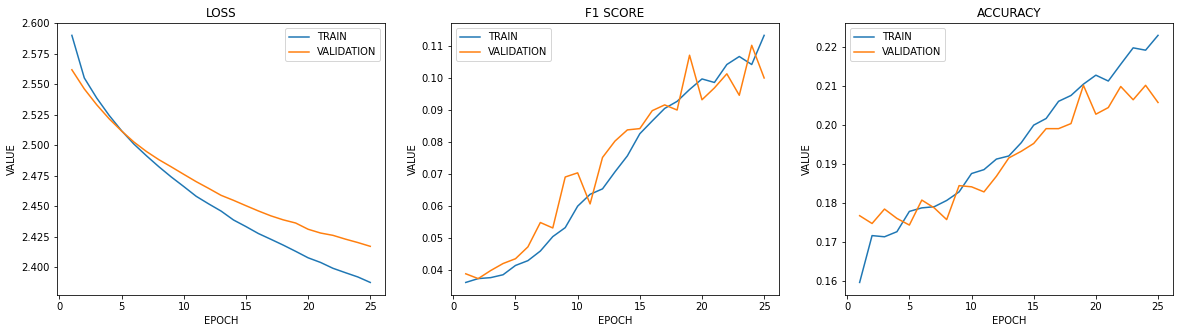


--MODEL--
Layers:  2
Initialization:  random_normal
Optimizer:  Adam
Learning rate:  0.001
Epochs:  25
Batch:  100

Best validation F1Score:  0.1008
Best validation Loss:  2.426100015640259
Best validation Accuracy:  0.2024

Mean epoch time (s):  2.6
Total time (s):  64.98


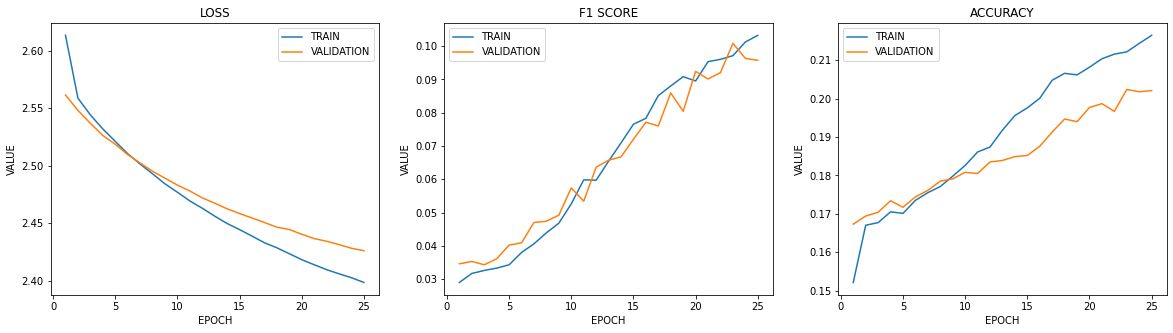


--MODEL--
Layers:  3
Initialization:  random_uniform
Optimizer:  Adam
Learning rate:  0.001
Epochs:  25
Batch:  100

Best validation F1Score:  0.1657
Best validation Loss:  2.344899892807007
Best validation Accuracy:  0.2362

Mean epoch time (s):  34.25
Total time (s):  856.35


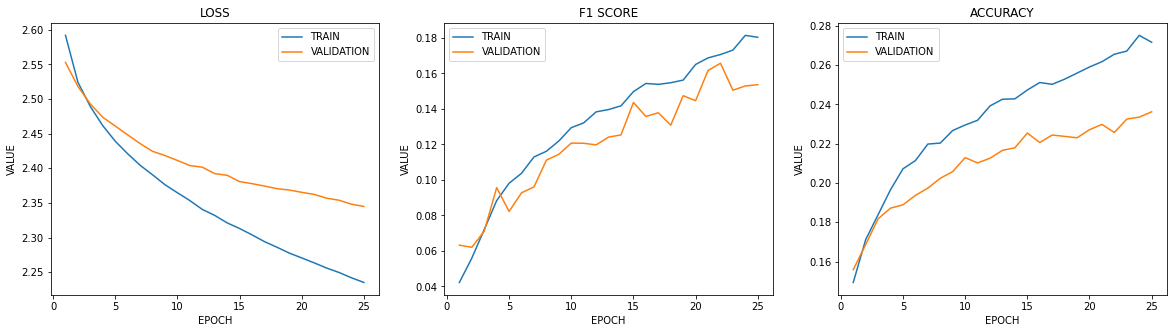


--MODEL--
Layers:  3
Initialization:  random_normal
Optimizer:  Adam
Learning rate:  0.001
Epochs:  25
Batch:  100

Best validation F1Score:  0.1691
Best validation Loss:  2.338200092315674
Best validation Accuracy:  0.2368

Mean epoch time (s):  34.13
Total time (s):  853.16


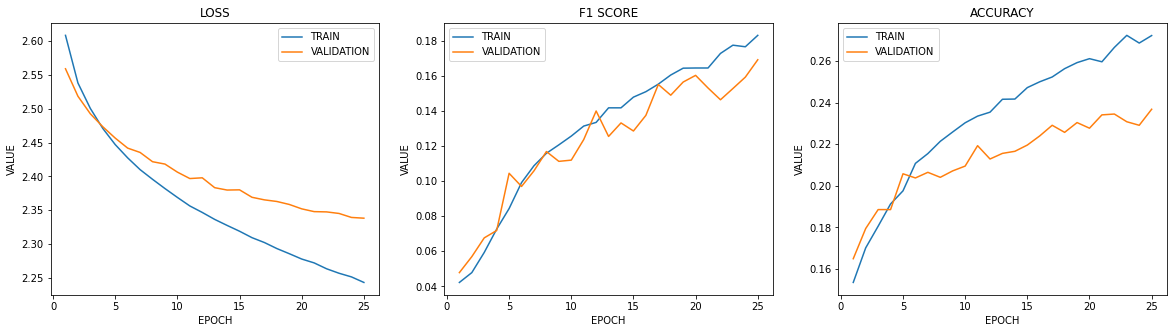

In [16]:
show_experiments_results(results_1)

In [23]:
# results_df_1 = results_df_1.sort_values('val_f1', ascending=False)
# results_df_1 = results_df_1.reset_index(inplace=False)
results_df_1[
    [
        'layers', 'initialization', 'optimizer', 'lr',
        'epochs', 'batch', 'epoch_num', 'val_loss',
        'val_f1', 'val_acc', 'total_time_s'
    ]
]

,layers,initialization,optimizer,lr,epochs,batch,epoch_num,val_loss,val_f1,val_acc,total_time_s
0,3,random_normal,Adam,0.001,25,100,25,2.3382,0.1691,0.2368,853.16
1,3,random_uniform,Adam,0.001,25,100,22,2.3569,0.1657,0.2257,856.35
2,2,random_uniform,Adam,0.001,25,100,24,2.4201,0.1102,0.2102,69.23
3,2,random_normal,Adam,0.001,25,100,23,2.4314,0.1008,0.2024,64.98


In [29]:
results_df_1.to_csv('./task1_results.csv')

--MODEL--
Layers:  3
Initialization:  random_normal
Optimizer:  Adam
Learning rate:  0.001
Epochs:  25
Batch:  100

Best validation F1Score:  0.1691
Best validation Loss:  2.338200092315674
Best validation Accuracy:  0.2368

Mean epoch time (s):  34.13
Total time (s):  853.16


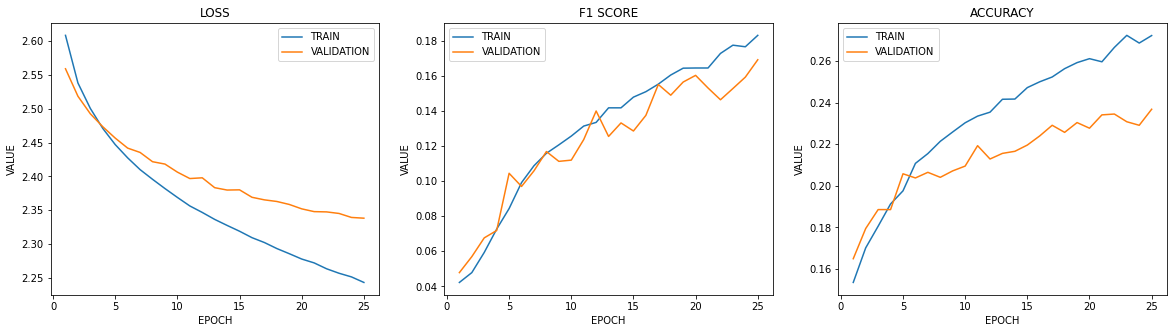

In [24]:
show_experiments_results([results_1[3]])

### Task 2 - epochs number, optimizer, lr, batch size

In [25]:
params = {
    'model': [Model_3_layers],
    'initialization': ['random_normal'],
    'optimizer': ['Adam', 'SGD'],
    'lr': [0.001, 0.01],
    'epochs': [20, 40],
    'batch': [100, 500]
}

results_df_2, results_2 = run_experiments(params)

  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 1, Train Loss: 2.6081743240356445, Train F1: 0.04267542436718941, Val Loss: 2.5704524517059326, Val F1: 0.05723558074435063


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 2, Train Loss: 2.536534070968628, Train F1: 0.05609084665775299, Val Loss: 2.5318613052368164, Val F1: 0.057744609502866424


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 3, Train Loss: 2.496290683746338, Train F1: 0.06719105690717697, Val Loss: 2.503160238265991, Val F1: 0.05937985521531654


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 4, Train Loss: 2.4668099880218506, Train F1: 0.077985480427742, Val Loss: 2.4822776317596436, Val F1: 0.09074236906940703


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 5, Train Loss: 2.443333148956299, Train F1: 0.09139424562454224, Val Loss: 2.4650397300720215, Val F1: 0.10162148401169646


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 6, Train Loss: 2.4245212078094482, Train F1: 0.10502342879772186, Val Loss: 2.4520270824432373, Val F1: 0.09125560089796446


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 7, Train Loss: 2.406646490097046, Train F1: 0.10839901864528656, Val Loss: 2.4404046535491943, Val F1: 0.12546970285219777


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 8, Train Loss: 2.3911890983581543, Train F1: 0.11780012398958206, Val Loss: 2.431074857711792, Val F1: 0.120750107803213


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 9, Train Loss: 2.3764724731445312, Train F1: 0.12091641128063202, Val Loss: 2.4210166931152344, Val F1: 0.11273220496417422


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 10, Train Loss: 2.3645412921905518, Train F1: 0.12839852273464203, Val Loss: 2.411600351333618, Val F1: 0.12456293107016003


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 11, Train Loss: 2.3533525466918945, Train F1: 0.1356932520866394, Val Loss: 2.404170274734497, Val F1: 0.12973652858263013


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 12, Train Loss: 2.3425607681274414, Train F1: 0.13667669892311096, Val Loss: 2.4026362895965576, Val F1: 0.1321257943088541


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 13, Train Loss: 2.3318917751312256, Train F1: 0.14294351637363434, Val Loss: 2.396559953689575, Val F1: 0.13194505333480708


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 14, Train Loss: 2.3232033252716064, Train F1: 0.14899341762065887, Val Loss: 2.3889029026031494, Val F1: 0.14597480149938805


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 15, Train Loss: 2.312750816345215, Train F1: 0.14858275651931763, Val Loss: 2.3822054862976074, Val F1: 0.13490955724461176


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 16, Train Loss: 2.302932024002075, Train F1: 0.15540090203285217, Val Loss: 2.379953384399414, Val F1: 0.12613148076829012


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 17, Train Loss: 2.2957630157470703, Train F1: 0.1574985235929489, Val Loss: 2.3713865280151367, Val F1: 0.139240872152959


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 18, Train Loss: 2.28816556930542, Train F1: 0.16230574250221252, Val Loss: 2.36926007270813, Val F1: 0.14589172922381413


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 19, Train Loss: 2.2788209915161133, Train F1: 0.16162653267383575, Val Loss: 2.367872714996338, Val F1: 0.13937177616698754


100%|██████████| 89/89 [00:31<00:00,  2.79it/s]


Epoch 20, Train Loss: 2.271892547607422, Train F1: 0.16782896220684052, Val Loss: 2.3578827381134033, Val F1: 0.14628000536162977


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1, Train Loss: 2.6775870323181152, Train F1: 0.044209882616996765, Val Loss: 2.615516185760498, Val F1: 0.044344802101413776


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 2, Train Loss: 2.615358829498291, Train F1: 0.04349539056420326, Val Loss: 2.600168228149414, Val F1: 0.04807703283595012


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 3, Train Loss: 2.598215341567993, Train F1: 0.04699910432100296, Val Loss: 2.5871541500091553, Val F1: 0.040722597786924705


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 4, Train Loss: 2.5843467712402344, Train F1: 0.04361705854535103, Val Loss: 2.575759172439575, Val F1: 0.04850035700227377


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 5, Train Loss: 2.574035882949829, Train F1: 0.04695434495806694, Val Loss: 2.5659334659576416, Val F1: 0.049441612450259916


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 6, Train Loss: 2.5634243488311768, Train F1: 0.04939626529812813, Val Loss: 2.557626724243164, Val F1: 0.049483716183664025


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 7, Train Loss: 2.5529987812042236, Train F1: 0.049222249537706375, Val Loss: 2.5489814281463623, Val F1: 0.04687148291301907


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 8, Train Loss: 2.5444931983947754, Train F1: 0.053167857229709625, Val Loss: 2.5419552326202393, Val F1: 0.04996608988631284


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 9, Train Loss: 2.5347495079040527, Train F1: 0.05465192347764969, Val Loss: 2.535524368286133, Val F1: 0.0454015684285392


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10, Train Loss: 2.5279719829559326, Train F1: 0.056573495268821716, Val Loss: 2.528554916381836, Val F1: 0.05205085348895867


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 11, Train Loss: 2.520230293273926, Train F1: 0.05898372456431389, Val Loss: 2.5224573612213135, Val F1: 0.05313329596991338


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 12, Train Loss: 2.5125272274017334, Train F1: 0.06120310351252556, Val Loss: 2.516761541366577, Val F1: 0.05560674282058007


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 13, Train Loss: 2.506108522415161, Train F1: 0.06343353539705276, Val Loss: 2.511335611343384, Val F1: 0.05499202576398323


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 14, Train Loss: 2.4998342990875244, Train F1: 0.06719034910202026, Val Loss: 2.506579637527466, Val F1: 0.06816101295777288


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 15, Train Loss: 2.4935085773468018, Train F1: 0.07160576432943344, Val Loss: 2.5022690296173096, Val F1: 0.0773415453455918


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 16, Train Loss: 2.4880740642547607, Train F1: 0.0765608474612236, Val Loss: 2.49696946144104, Val F1: 0.07122966385441538


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 17, Train Loss: 2.4818482398986816, Train F1: 0.07962501794099808, Val Loss: 2.492267370223999, Val F1: 0.0769020043082748


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 18, Train Loss: 2.4764912128448486, Train F1: 0.08028522878885269, Val Loss: 2.4883594512939453, Val F1: 0.08083867643232844


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 19, Train Loss: 2.470881462097168, Train F1: 0.08444413542747498, Val Loss: 2.4841082096099854, Val F1: 0.08124925934004779


100%|██████████| 18/18 [00:21<00:00,  1.20s/it]


Epoch 20, Train Loss: 2.466193675994873, Train F1: 0.08798423409461975, Val Loss: 2.480318069458008, Val F1: 0.07812119349839883


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 1, Train Loss: 2.5969183444976807, Train F1: 0.04531821608543396, Val Loss: 2.566206455230713, Val F1: 0.05663550222361452


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 2, Train Loss: 2.52510404586792, Train F1: 0.05273761227726936, Val Loss: 2.5272481441497803, Val F1: 0.054562881892103544


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 3, Train Loss: 2.487337589263916, Train F1: 0.06608583778142929, Val Loss: 2.508636951446533, Val F1: 0.04744411211833536


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 4, Train Loss: 2.457893133163452, Train F1: 0.08066027611494064, Val Loss: 2.4810903072357178, Val F1: 0.09871064641806573


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 5, Train Loss: 2.4339792728424072, Train F1: 0.09558089077472687, Val Loss: 2.465886116027832, Val F1: 0.09042224220264534


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 6, Train Loss: 2.414970636367798, Train F1: 0.10333415865898132, Val Loss: 2.449087381362915, Val F1: 0.10454261134055144


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 7, Train Loss: 2.3953988552093506, Train F1: 0.11378461867570877, Val Loss: 2.437445878982544, Val F1: 0.1210053102235196


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 8, Train Loss: 2.380044460296631, Train F1: 0.12365549057722092, Val Loss: 2.427009105682373, Val F1: 0.1268093517154827


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 9, Train Loss: 2.3682308197021484, Train F1: 0.13221591711044312, Val Loss: 2.418954610824585, Val F1: 0.12925645141849001


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 10, Train Loss: 2.3554341793060303, Train F1: 0.13267427682876587, Val Loss: 2.4093177318573, Val F1: 0.13245132317432068


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 11, Train Loss: 2.3431320190429688, Train F1: 0.13822220265865326, Val Loss: 2.4094624519348145, Val F1: 0.1302041677110189


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 12, Train Loss: 2.3319218158721924, Train F1: 0.14216910302639008, Val Loss: 2.402245283126831, Val F1: 0.14152610412816483


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 13, Train Loss: 2.319875717163086, Train F1: 0.1539306491613388, Val Loss: 2.392528772354126, Val F1: 0.13092601350334795


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 14, Train Loss: 2.313016891479492, Train F1: 0.14816294610500336, Val Loss: 2.388542890548706, Val F1: 0.15398481068698988


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 15, Train Loss: 2.3026981353759766, Train F1: 0.15904377400875092, Val Loss: 2.381956100463867, Val F1: 0.15499551388482685


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 16, Train Loss: 2.2918050289154053, Train F1: 0.16002343595027924, Val Loss: 2.375016689300537, Val F1: 0.15765363015754322


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 17, Train Loss: 2.2842202186584473, Train F1: 0.16291430592536926, Val Loss: 2.3755099773406982, Val F1: 0.14795743037123563


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 18, Train Loss: 2.276540517807007, Train F1: 0.17177098989486694, Val Loss: 2.3672144412994385, Val F1: 0.14697422182053446


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 19, Train Loss: 2.2675740718841553, Train F1: 0.1681661605834961, Val Loss: 2.3641364574432373, Val F1: 0.15851332351857625


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 20, Train Loss: 2.2608652114868164, Train F1: 0.17534731328487396, Val Loss: 2.362053871154785, Val F1: 0.15638033513876612


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 21, Train Loss: 2.2500412464141846, Train F1: 0.18212084472179413, Val Loss: 2.3578522205352783, Val F1: 0.15334581081229712


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 22, Train Loss: 2.2442290782928467, Train F1: 0.17509673535823822, Val Loss: 2.357724905014038, Val F1: 0.1605082804374077


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 23, Train Loss: 2.2351863384246826, Train F1: 0.18112564086914062, Val Loss: 2.3554527759552, Val F1: 0.1509603241566925


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 24, Train Loss: 2.2292864322662354, Train F1: 0.1839996874332428, Val Loss: 2.3526833057403564, Val F1: 0.15694472276412788


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 25, Train Loss: 2.2228190898895264, Train F1: 0.1853039413690567, Val Loss: 2.345794916152954, Val F1: 0.16994866702006856


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 26, Train Loss: 2.215503692626953, Train F1: 0.18835844099521637, Val Loss: 2.3469486236572266, Val F1: 0.16496567640026485


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 27, Train Loss: 2.207791566848755, Train F1: 0.19877076148986816, Val Loss: 2.3487064838409424, Val F1: 0.17026443078411763


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 28, Train Loss: 2.2021050453186035, Train F1: 0.19752191007137299, Val Loss: 2.3415610790252686, Val F1: 0.16479991610740666


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 29, Train Loss: 2.1965103149414062, Train F1: 0.19811846315860748, Val Loss: 2.33685564994812, Val F1: 0.1675089608654369


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 30, Train Loss: 2.1891143321990967, Train F1: 0.20218351483345032, Val Loss: 2.335374593734741, Val F1: 0.16003591809146675


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 31, Train Loss: 2.1815133094787598, Train F1: 0.20151442289352417, Val Loss: 2.3336236476898193, Val F1: 0.17242066565701464


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 32, Train Loss: 2.1769070625305176, Train F1: 0.20512673258781433, Val Loss: 2.327519655227661, Val F1: 0.16613401742207695


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 33, Train Loss: 2.169240951538086, Train F1: 0.21229566633701324, Val Loss: 2.328336238861084, Val F1: 0.17602557583224815


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 34, Train Loss: 2.1641957759857178, Train F1: 0.21603670716285706, Val Loss: 2.3260810375213623, Val F1: 0.18869402775509675


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 35, Train Loss: 2.1584348678588867, Train F1: 0.2163383811712265, Val Loss: 2.320122003555298, Val F1: 0.17362166199885867


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 36, Train Loss: 2.1516029834747314, Train F1: 0.22135333716869354, Val Loss: 2.324716329574585, Val F1: 0.16693782736175508


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 37, Train Loss: 2.145512342453003, Train F1: 0.22008828818798065, Val Loss: 2.3202686309814453, Val F1: 0.1824200170482215


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 38, Train Loss: 2.1404306888580322, Train F1: 0.2257889062166214, Val Loss: 2.3133881092071533, Val F1: 0.18234440068173166


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 39, Train Loss: 2.1355228424072266, Train F1: 0.2268933355808258, Val Loss: 2.314157485961914, Val F1: 0.18089561739648732


100%|██████████| 89/89 [00:34<00:00,  2.60it/s]


Epoch 40, Train Loss: 2.12721848487854, Train F1: 0.23248614370822906, Val Loss: 2.3161087036132812, Val F1: 0.18827986965023186


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1, Train Loss: 2.6783177852630615, Train F1: 0.0428786538541317, Val Loss: 2.589715003967285, Val F1: 0.04181860438027778


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 2, Train Loss: 2.575827121734619, Train F1: 0.045275624841451645, Val Loss: 2.574406147003174, Val F1: 0.04883309182698316


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 3, Train Loss: 2.562267780303955, Train F1: 0.048145487904548645, Val Loss: 2.563426971435547, Val F1: 0.049718639009555636


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 4, Train Loss: 2.550840139389038, Train F1: 0.0503053218126297, Val Loss: 2.5549962520599365, Val F1: 0.05171050192032061


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 5, Train Loss: 2.5405781269073486, Train F1: 0.051626674830913544, Val Loss: 2.546034097671509, Val F1: 0.058244524530649426


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 6, Train Loss: 2.531215190887451, Train F1: 0.053025923669338226, Val Loss: 2.538400888442993, Val F1: 0.059274637288563595


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 7, Train Loss: 2.521394729614258, Train F1: 0.05710938945412636, Val Loss: 2.531198501586914, Val F1: 0.059320828198504746


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 8, Train Loss: 2.5139641761779785, Train F1: 0.05936190113425255, Val Loss: 2.524531126022339, Val F1: 0.06839752935078154


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 9, Train Loss: 2.5056779384613037, Train F1: 0.06370816379785538, Val Loss: 2.5184738636016846, Val F1: 0.06329687499322366


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10, Train Loss: 2.49924898147583, Train F1: 0.0637223944067955, Val Loss: 2.51373028755188, Val F1: 0.08103263661267122


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 11, Train Loss: 2.491539239883423, Train F1: 0.07028903812170029, Val Loss: 2.5078814029693604, Val F1: 0.06608208380290506


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 12, Train Loss: 2.486326217651367, Train F1: 0.06977487355470657, Val Loss: 2.5025575160980225, Val F1: 0.07754666873807002


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 13, Train Loss: 2.479271411895752, Train F1: 0.07425246387720108, Val Loss: 2.4975295066833496, Val F1: 0.06825705011511597


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 14, Train Loss: 2.473278284072876, Train F1: 0.0766211450099945, Val Loss: 2.493706226348877, Val F1: 0.06500169049985659


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 15, Train Loss: 2.466890335083008, Train F1: 0.07995866239070892, Val Loss: 2.489342212677002, Val F1: 0.07906959635470283


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 16, Train Loss: 2.462193727493286, Train F1: 0.07997389882802963, Val Loss: 2.485659599304199, Val F1: 0.09334271685960849


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 17, Train Loss: 2.4568209648132324, Train F1: 0.08860945701599121, Val Loss: 2.4815282821655273, Val F1: 0.08728899783957485


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 18, Train Loss: 2.4511332511901855, Train F1: 0.09021031856536865, Val Loss: 2.477889060974121, Val F1: 0.08427403667761427


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 19, Train Loss: 2.4465830326080322, Train F1: 0.09145265817642212, Val Loss: 2.4736459255218506, Val F1: 0.0932908944927333


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 20, Train Loss: 2.441983938217163, Train F1: 0.09533437341451645, Val Loss: 2.470688581466675, Val F1: 0.09788157118859377


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 21, Train Loss: 2.437927007675171, Train F1: 0.09844110161066055, Val Loss: 2.46730375289917, Val F1: 0.09488329132047175


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 22, Train Loss: 2.4331228733062744, Train F1: 0.10176298767328262, Val Loss: 2.4636783599853516, Val F1: 0.10263175833598306


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 23, Train Loss: 2.428838014602661, Train F1: 0.10510602593421936, Val Loss: 2.461595058441162, Val F1: 0.10068398704732963


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 24, Train Loss: 2.4254045486450195, Train F1: 0.10841301083564758, Val Loss: 2.457627058029175, Val F1: 0.1072224413825736


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 25, Train Loss: 2.4198312759399414, Train F1: 0.10963582992553711, Val Loss: 2.455193042755127, Val F1: 0.09977221758068824


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 26, Train Loss: 2.4171416759490967, Train F1: 0.11274401098489761, Val Loss: 2.451944589614868, Val F1: 0.10878291684141758


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 27, Train Loss: 2.4126782417297363, Train F1: 0.11449188739061356, Val Loss: 2.449867010116577, Val F1: 0.10827644089381809


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 28, Train Loss: 2.4099485874176025, Train F1: 0.11782220751047134, Val Loss: 2.447072982788086, Val F1: 0.11229879125285382


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 29, Train Loss: 2.4053425788879395, Train F1: 0.12095861881971359, Val Loss: 2.4445340633392334, Val F1: 0.1113323967666808


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 30, Train Loss: 2.402162551879883, Train F1: 0.12269274145364761, Val Loss: 2.4419310092926025, Val F1: 0.12089832839560197


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 31, Train Loss: 2.39859676361084, Train F1: 0.12292167544364929, Val Loss: 2.43974232673645, Val F1: 0.11664505685705982


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 32, Train Loss: 2.394993782043457, Train F1: 0.12691932916641235, Val Loss: 2.437349557876587, Val F1: 0.11265422379205094


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 33, Train Loss: 2.391922950744629, Train F1: 0.12387189269065857, Val Loss: 2.4353413581848145, Val F1: 0.12238287246204309


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 34, Train Loss: 2.388436794281006, Train F1: 0.129169762134552, Val Loss: 2.433485746383667, Val F1: 0.11696614033956383


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 35, Train Loss: 2.3867132663726807, Train F1: 0.12610924243927002, Val Loss: 2.4312541484832764, Val F1: 0.12410763449605568


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 36, Train Loss: 2.3824098110198975, Train F1: 0.1331959217786789, Val Loss: 2.429263114929199, Val F1: 0.12692732949593635


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 37, Train Loss: 2.3800110816955566, Train F1: 0.13470453023910522, Val Loss: 2.4271535873413086, Val F1: 0.11496711197961383


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 38, Train Loss: 2.3772058486938477, Train F1: 0.13406434655189514, Val Loss: 2.425790548324585, Val F1: 0.12306690906727025


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 39, Train Loss: 2.3749585151672363, Train F1: 0.13771088421344757, Val Loss: 2.4234862327575684, Val F1: 0.12804366039472606


100%|██████████| 18/18 [00:21<00:00,  1.20s/it]


Epoch 40, Train Loss: 2.3702313899993896, Train F1: 0.1411663293838501, Val Loss: 2.4216113090515137, Val F1: 0.12406409606262019


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 1, Train Loss: 2.5477492809295654, Train F1: 0.06541800498962402, Val Loss: 2.449366569519043, Val F1: 0.10609118156694738


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 2, Train Loss: 2.402583122253418, Train F1: 0.11161208152770996, Val Loss: 2.421248197555542, Val F1: 0.10842065943460728


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 3, Train Loss: 2.3469557762145996, Train F1: 0.13635438680648804, Val Loss: 2.405377149581909, Val F1: 0.14014569383995146


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 4, Train Loss: 2.3091917037963867, Train F1: 0.15517184138298035, Val Loss: 2.362239360809326, Val F1: 0.14358225799421984


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 5, Train Loss: 2.273803472518921, Train F1: 0.1673802137374878, Val Loss: 2.3971338272094727, Val F1: 0.1681098484322032


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 6, Train Loss: 2.239393949508667, Train F1: 0.18517842888832092, Val Loss: 2.3999056816101074, Val F1: 0.16398542254709497


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 7, Train Loss: 2.2032883167266846, Train F1: 0.19555586576461792, Val Loss: 2.377243995666504, Val F1: 0.1700762117780017


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 8, Train Loss: 2.178687334060669, Train F1: 0.2058907449245453, Val Loss: 2.3992843627929688, Val F1: 0.14362334361795523


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 9, Train Loss: 2.1566662788391113, Train F1: 0.21781069040298462, Val Loss: 2.4558353424072266, Val F1: 0.1492473283726559


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 10, Train Loss: 2.121664524078369, Train F1: 0.23193584382534027, Val Loss: 2.345313310623169, Val F1: 0.1745503316123685


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 11, Train Loss: 2.0908617973327637, Train F1: 0.24699342250823975, Val Loss: 2.3984179496765137, Val F1: 0.17964072638192655


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 12, Train Loss: 2.0593371391296387, Train F1: 0.2621406614780426, Val Loss: 2.6258857250213623, Val F1: 0.10297798823452618


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 13, Train Loss: 2.0369277000427246, Train F1: 0.2748531401157379, Val Loss: 2.337517738342285, Val F1: 0.19137880142092042


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 14, Train Loss: 2.0111618041992188, Train F1: 0.27976787090301514, Val Loss: 2.292418956756592, Val F1: 0.20642334867362264


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 15, Train Loss: 1.9792829751968384, Train F1: 0.29337742924690247, Val Loss: 2.408132553100586, Val F1: 0.16368893019994207


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 16, Train Loss: 1.9433542490005493, Train F1: 0.31085726618766785, Val Loss: 2.31494402885437, Val F1: 0.20021300796052266


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 17, Train Loss: 1.9109485149383545, Train F1: 0.3252255916595459, Val Loss: 2.519498825073242, Val F1: 0.1405624803764451


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 18, Train Loss: 1.8932065963745117, Train F1: 0.3317420780658722, Val Loss: 2.33329176902771, Val F1: 0.19710966519053263


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 19, Train Loss: 1.8291358947753906, Train F1: 0.3546072840690613, Val Loss: 2.2841858863830566, Val F1: 0.2127377533535865


100%|██████████| 89/89 [00:33<00:00,  2.62it/s]


Epoch 20, Train Loss: 1.8219949007034302, Train F1: 0.3656945526599884, Val Loss: 2.5152313709259033, Val F1: 0.14138445715934098


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1, Train Loss: 2.663215398788452, Train F1: 0.04340716451406479, Val Loss: 2.5264852046966553, Val F1: 0.04894709551152338


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 2, Train Loss: 2.512665271759033, Train F1: 0.06346159428358078, Val Loss: 2.4958274364471436, Val F1: 0.11497196831999269


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 3, Train Loss: 2.4665162563323975, Train F1: 0.09070711582899094, Val Loss: 2.47575044631958, Val F1: 0.09054013478109037


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 4, Train Loss: 2.4224398136138916, Train F1: 0.1084253340959549, Val Loss: 2.453230857849121, Val F1: 0.0905880822451507


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 5, Train Loss: 2.401360511779785, Train F1: 0.11861415952444077, Val Loss: 2.459800958633423, Val F1: 0.08773823409552924


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 6, Train Loss: 2.3838796615600586, Train F1: 0.12356584519147873, Val Loss: 2.4081873893737793, Val F1: 0.11531821522880752


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 7, Train Loss: 2.3572943210601807, Train F1: 0.13578923046588898, Val Loss: 2.41129469871521, Val F1: 0.09803094617744594


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 8, Train Loss: 2.3457581996917725, Train F1: 0.14272284507751465, Val Loss: 2.3908016681671143, Val F1: 0.1510878901874632


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 9, Train Loss: 2.3393988609313965, Train F1: 0.14389127492904663, Val Loss: 2.39487624168396, Val F1: 0.13103342232292833


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10, Train Loss: 2.3148193359375, Train F1: 0.15808966755867004, Val Loss: 2.376376152038574, Val F1: 0.1301082393012929


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 11, Train Loss: 2.301689386367798, Train F1: 0.15772445499897003, Val Loss: 2.41235089302063, Val F1: 0.14599739219895463


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 12, Train Loss: 2.3006081581115723, Train F1: 0.16522613167762756, Val Loss: 2.3732047080993652, Val F1: 0.13666514144669217


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 13, Train Loss: 2.281416177749634, Train F1: 0.16863110661506653, Val Loss: 2.3549108505249023, Val F1: 0.15827718971679203


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 14, Train Loss: 2.269167423248291, Train F1: 0.1764504313468933, Val Loss: 2.365060806274414, Val F1: 0.1769787917190991


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 15, Train Loss: 2.2551543712615967, Train F1: 0.18634870648384094, Val Loss: 2.4352567195892334, Val F1: 0.10024433445917001


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 16, Train Loss: 2.2520065307617188, Train F1: 0.18270641565322876, Val Loss: 2.356692314147949, Val F1: 0.16618234922733946


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 17, Train Loss: 2.2407658100128174, Train F1: 0.18517310917377472, Val Loss: 2.3396964073181152, Val F1: 0.18136766326439993


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 18, Train Loss: 2.239871025085449, Train F1: 0.19024226069450378, Val Loss: 2.343087673187256, Val F1: 0.15899162731636335


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 19, Train Loss: 2.2165825366973877, Train F1: 0.19827967882156372, Val Loss: 2.3712425231933594, Val F1: 0.14149321106646243


100%|██████████| 18/18 [00:21<00:00,  1.19s/it]


Epoch 20, Train Loss: 2.2174901962280273, Train F1: 0.20016154646873474, Val Loss: 2.39262056350708, Val F1: 0.12890459996981982


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 1, Train Loss: 2.5478219985961914, Train F1: 0.06587468832731247, Val Loss: 2.5034470558166504, Val F1: 0.058750540483107794


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 2, Train Loss: 2.408311128616333, Train F1: 0.11359243839979172, Val Loss: 2.45945143699646, Val F1: 0.1070404276117415


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 3, Train Loss: 2.3529133796691895, Train F1: 0.13283847272396088, Val Loss: 2.458613872528076, Val F1: 0.11644183006776022


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 4, Train Loss: 2.309386730194092, Train F1: 0.1504252851009369, Val Loss: 2.427370548248291, Val F1: 0.14821195345455893


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 5, Train Loss: 2.2685928344726562, Train F1: 0.1645275503396988, Val Loss: 2.350179433822632, Val F1: 0.14074341898458656


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 6, Train Loss: 2.236931324005127, Train F1: 0.1820577085018158, Val Loss: 2.408073902130127, Val F1: 0.16710903348085937


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 7, Train Loss: 2.214871883392334, Train F1: 0.1917572170495987, Val Loss: 2.379032611846924, Val F1: 0.15551770405844298


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 8, Train Loss: 2.1805505752563477, Train F1: 0.20529815554618835, Val Loss: 2.37203311920166, Val F1: 0.16048620970080332


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 9, Train Loss: 2.1617214679718018, Train F1: 0.21363753080368042, Val Loss: 2.4632201194763184, Val F1: 0.15066698342111004


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 10, Train Loss: 2.1214170455932617, Train F1: 0.2294328212738037, Val Loss: 2.4039719104766846, Val F1: 0.16104678680574563


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 11, Train Loss: 2.0933260917663574, Train F1: 0.24200724065303802, Val Loss: 2.283914566040039, Val F1: 0.19383623455390706


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 12, Train Loss: 2.062930107116699, Train F1: 0.2543241083621979, Val Loss: 2.3586316108703613, Val F1: 0.14440356597732001


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 13, Train Loss: 2.0440175533294678, Train F1: 0.2665007412433624, Val Loss: 2.338789701461792, Val F1: 0.1862074591150944


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 14, Train Loss: 2.0198776721954346, Train F1: 0.28252413868904114, Val Loss: 2.3716559410095215, Val F1: 0.1497208741041843


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 15, Train Loss: 1.9846843481063843, Train F1: 0.29066988825798035, Val Loss: 2.3431222438812256, Val F1: 0.21153745515517294


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 16, Train Loss: 1.9424437284469604, Train F1: 0.31253477931022644, Val Loss: 2.4198732376098633, Val F1: 0.18834117312468623


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 17, Train Loss: 1.9321163892745972, Train F1: 0.3120008409023285, Val Loss: 2.3127405643463135, Val F1: 0.21572516419626978


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 18, Train Loss: 1.8876601457595825, Train F1: 0.3307456076145172, Val Loss: 2.382674217224121, Val F1: 0.184612182939601


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 19, Train Loss: 1.8404291868209839, Train F1: 0.3505425751209259, Val Loss: 2.364470958709717, Val F1: 0.20767809588846062


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 20, Train Loss: 1.8239331245422363, Train F1: 0.35892099142074585, Val Loss: 2.501643180847168, Val F1: 0.13217610021864984


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 21, Train Loss: 1.7934746742248535, Train F1: 0.3732745051383972, Val Loss: 2.305756092071533, Val F1: 0.24237208482583253


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 22, Train Loss: 1.7546899318695068, Train F1: 0.3877863585948944, Val Loss: 2.3272712230682373, Val F1: 0.21293870101656795


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 23, Train Loss: 1.7423200607299805, Train F1: 0.393119215965271, Val Loss: 2.3398003578186035, Val F1: 0.21691642623318147


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 24, Train Loss: 1.680936336517334, Train F1: 0.4203110635280609, Val Loss: 2.4683940410614014, Val F1: 0.18275721016651322


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 25, Train Loss: 1.6691570281982422, Train F1: 0.42637544870376587, Val Loss: 2.3743178844451904, Val F1: 0.22518790027410823


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 26, Train Loss: 1.6001598834991455, Train F1: 0.4522281885147095, Val Loss: 2.3303284645080566, Val F1: 0.24906046002577784


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 27, Train Loss: 1.6092350482940674, Train F1: 0.4549539089202881, Val Loss: 2.393916130065918, Val F1: 0.19286553266379539


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 28, Train Loss: 1.5610809326171875, Train F1: 0.4785057306289673, Val Loss: 2.3814375400543213, Val F1: 0.20991467927850474


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 29, Train Loss: 1.5427097082138062, Train F1: 0.48018354177474976, Val Loss: 2.278909683227539, Val F1: 0.23378612031548732


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 30, Train Loss: 1.4847978353500366, Train F1: 0.5022931694984436, Val Loss: 2.6395342350006104, Val F1: 0.22018577812080445


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 31, Train Loss: 1.4767577648162842, Train F1: 0.5078942179679871, Val Loss: 2.3291406631469727, Val F1: 0.24605522349714773


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 32, Train Loss: 1.4127784967422485, Train F1: 0.534351110458374, Val Loss: 2.649775505065918, Val F1: 0.17254408071283517


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 33, Train Loss: 1.4031243324279785, Train F1: 0.5347940325737, Val Loss: 2.4176688194274902, Val F1: 0.22768668328473401


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 34, Train Loss: 1.3482667207717896, Train F1: 0.5485072731971741, Val Loss: 2.5636658668518066, Val F1: 0.22209068644978913


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 35, Train Loss: 1.313585638999939, Train F1: 0.5717121362686157, Val Loss: 2.5368905067443848, Val F1: 0.248311370707149


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 36, Train Loss: 1.2762120962142944, Train F1: 0.5947251319885254, Val Loss: 2.55092453956604, Val F1: 0.21432281961149716


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 37, Train Loss: 1.2596430778503418, Train F1: 0.592204749584198, Val Loss: 2.702446699142456, Val F1: 0.20904235559531997


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 38, Train Loss: 1.2266206741333008, Train F1: 0.6073089241981506, Val Loss: 2.5912506580352783, Val F1: 0.21371642085287498


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 39, Train Loss: 1.1883573532104492, Train F1: 0.6164447069168091, Val Loss: 2.3871870040893555, Val F1: 0.2663857010234417


100%|██████████| 89/89 [00:31<00:00,  2.81it/s]


Epoch 40, Train Loss: 1.131782054901123, Train F1: 0.6335131525993347, Val Loss: 2.7218124866485596, Val F1: 0.19995705570207858


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1, Train Loss: 2.7365574836730957, Train F1: 0.036939263343811035, Val Loss: 2.549675464630127, Val F1: 0.044235337395844156


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 2, Train Loss: 2.5306341648101807, Train F1: 0.053419698029756546, Val Loss: 2.5014123916625977, Val F1: 0.05764686276544819


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 3, Train Loss: 2.4751243591308594, Train F1: 0.0791962519288063, Val Loss: 2.506643533706665, Val F1: 0.04654924147985443


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 4, Train Loss: 2.4323599338531494, Train F1: 0.10278137773275375, Val Loss: 2.4672160148620605, Val F1: 0.07050470735736913


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 5, Train Loss: 2.405475378036499, Train F1: 0.11205989867448807, Val Loss: 2.4613912105560303, Val F1: 0.10328371114009016


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 6, Train Loss: 2.3905019760131836, Train F1: 0.11565376818180084, Val Loss: 2.4147567749023438, Val F1: 0.13147335286121134


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 7, Train Loss: 2.3674492835998535, Train F1: 0.13547582924365997, Val Loss: 2.4262452125549316, Val F1: 0.14660993427449134


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 8, Train Loss: 2.3437626361846924, Train F1: 0.14031389355659485, Val Loss: 2.4148240089416504, Val F1: 0.1443174799507949


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 9, Train Loss: 2.3354456424713135, Train F1: 0.13815352320671082, Val Loss: 2.383795738220215, Val F1: 0.13643790990327379


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10, Train Loss: 2.3186328411102295, Train F1: 0.15120476484298706, Val Loss: 2.377213954925537, Val F1: 0.14414634557730863


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 11, Train Loss: 2.3060219287872314, Train F1: 0.1576583981513977, Val Loss: 2.3867897987365723, Val F1: 0.14766364662759016


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 12, Train Loss: 2.289679765701294, Train F1: 0.16092893481254578, Val Loss: 2.3757989406585693, Val F1: 0.1370805817844387


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 13, Train Loss: 2.2941293716430664, Train F1: 0.16094787418842316, Val Loss: 2.367814302444458, Val F1: 0.15959722975130536


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 14, Train Loss: 2.2657785415649414, Train F1: 0.17657095193862915, Val Loss: 2.3858885765075684, Val F1: 0.11964884884406743


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 15, Train Loss: 2.258701801300049, Train F1: 0.1794005036354065, Val Loss: 2.3840172290802, Val F1: 0.1420693409475985


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 16, Train Loss: 2.259037971496582, Train F1: 0.17569097876548767, Val Loss: 2.364290714263916, Val F1: 0.1424150779435685


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 17, Train Loss: 2.2323625087738037, Train F1: 0.19032366573810577, Val Loss: 2.392536163330078, Val F1: 0.15435217776550436


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 18, Train Loss: 2.24629282951355, Train F1: 0.19013364613056183, Val Loss: 2.413351058959961, Val F1: 0.13933461903462988


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 19, Train Loss: 2.225724458694458, Train F1: 0.19757458567619324, Val Loss: 2.3505258560180664, Val F1: 0.1582407223441331


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 20, Train Loss: 2.229374647140503, Train F1: 0.19188788533210754, Val Loss: 2.3503358364105225, Val F1: 0.13813747126105763


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 21, Train Loss: 2.224475145339966, Train F1: 0.1985195428133011, Val Loss: 2.3438405990600586, Val F1: 0.16610105247714937


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 22, Train Loss: 2.1919775009155273, Train F1: 0.2067916989326477, Val Loss: 2.3849289417266846, Val F1: 0.18531824706211603


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 23, Train Loss: 2.2075839042663574, Train F1: 0.2036433219909668, Val Loss: 2.4036498069763184, Val F1: 0.1835007900647235


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 24, Train Loss: 2.1799867153167725, Train F1: 0.21972531080245972, Val Loss: 2.389441967010498, Val F1: 0.10862347501211851


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 25, Train Loss: 2.2037312984466553, Train F1: 0.2041228860616684, Val Loss: 2.3778278827667236, Val F1: 0.16198944798200407


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 26, Train Loss: 2.164973258972168, Train F1: 0.22885078191757202, Val Loss: 2.326286792755127, Val F1: 0.15708566747399558


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 27, Train Loss: 2.1856446266174316, Train F1: 0.21706601977348328, Val Loss: 2.3398420810699463, Val F1: 0.1709767567439111


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 28, Train Loss: 2.15328049659729, Train F1: 0.233206644654274, Val Loss: 2.3472397327423096, Val F1: 0.17412524697261214


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 29, Train Loss: 2.1603236198425293, Train F1: 0.23713935911655426, Val Loss: 2.341132640838623, Val F1: 0.17651996994024266


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 30, Train Loss: 2.152714252471924, Train F1: 0.23188278079032898, Val Loss: 2.3314623832702637, Val F1: 0.1741008624263253


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 31, Train Loss: 2.136155366897583, Train F1: 0.2422916293144226, Val Loss: 2.3566091060638428, Val F1: 0.1542489926453732


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 32, Train Loss: 2.1416256427764893, Train F1: 0.2365788370370865, Val Loss: 2.367427110671997, Val F1: 0.1623320592269652


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 33, Train Loss: 2.1200883388519287, Train F1: 0.25144487619400024, Val Loss: 2.298658847808838, Val F1: 0.19173199784393194


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 34, Train Loss: 2.130805492401123, Train F1: 0.24168559908866882, Val Loss: 2.3538448810577393, Val F1: 0.14497504703084835


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 35, Train Loss: 2.1163127422332764, Train F1: 0.25740084052085876, Val Loss: 2.313371419906616, Val F1: 0.16812326390188634


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 36, Train Loss: 2.086243152618408, Train F1: 0.25938937067985535, Val Loss: 2.3577351570129395, Val F1: 0.1655516017745183


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 37, Train Loss: 2.1087443828582764, Train F1: 0.254777193069458, Val Loss: 2.328073024749756, Val F1: 0.18711817466098393


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 38, Train Loss: 2.0913288593292236, Train F1: 0.262772798538208, Val Loss: 2.3055930137634277, Val F1: 0.19783532559988395


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 39, Train Loss: 2.0941174030303955, Train F1: 0.26060765981674194, Val Loss: 2.356252670288086, Val F1: 0.18770964319494157


100%|██████████| 18/18 [00:18<00:00,  1.04s/it]


Epoch 40, Train Loss: 2.086172580718994, Train F1: 0.2659515142440796, Val Loss: 2.327406644821167, Val F1: 0.20546507714014178


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 1, Train Loss: 2.6180081367492676, Train F1: 0.04435495287179947, Val Loss: 2.5495352745056152, Val F1: 0.04961950866522923


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 2, Train Loss: 2.527177572250366, Train F1: 0.05775158479809761, Val Loss: 2.5181305408477783, Val F1: 0.05698387746085141


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 3, Train Loss: 2.4882993698120117, Train F1: 0.07368446886539459, Val Loss: 2.493995428085327, Val F1: 0.0827630350485312


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 4, Train Loss: 2.458141803741455, Train F1: 0.0874420627951622, Val Loss: 2.4780948162078857, Val F1: 0.07344504330156446


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 5, Train Loss: 2.4353482723236084, Train F1: 0.09732615202665329, Val Loss: 2.46284556388855, Val F1: 0.07718183519517152


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 6, Train Loss: 2.4149951934814453, Train F1: 0.10986203700304031, Val Loss: 2.442995548248291, Val F1: 0.10961997375765628


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 7, Train Loss: 2.3981854915618896, Train F1: 0.11415571719408035, Val Loss: 2.4380791187286377, Val F1: 0.12444278680245659


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 8, Train Loss: 2.382134199142456, Train F1: 0.12203837931156158, Val Loss: 2.4198572635650635, Val F1: 0.12946814514817093


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 9, Train Loss: 2.368206024169922, Train F1: 0.12871038913726807, Val Loss: 2.413351058959961, Val F1: 0.12261079451049847


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 10, Train Loss: 2.354840040206909, Train F1: 0.13230109214782715, Val Loss: 2.4061944484710693, Val F1: 0.12737743517716507


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 11, Train Loss: 2.3433499336242676, Train F1: 0.1387535035610199, Val Loss: 2.3985252380371094, Val F1: 0.13366559729282076


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 12, Train Loss: 2.3314058780670166, Train F1: 0.1443716138601303, Val Loss: 2.391040563583374, Val F1: 0.139977990087564


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 13, Train Loss: 2.3215155601501465, Train F1: 0.14422912895679474, Val Loss: 2.3855159282684326, Val F1: 0.1390746559962845


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 14, Train Loss: 2.3117024898529053, Train F1: 0.14662444591522217, Val Loss: 2.375447988510132, Val F1: 0.13886447231849655


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 15, Train Loss: 2.301274299621582, Train F1: 0.15064109861850739, Val Loss: 2.381258487701416, Val F1: 0.15416931117378857


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 16, Train Loss: 2.2923338413238525, Train F1: 0.15986734628677368, Val Loss: 2.366466999053955, Val F1: 0.15241277592871644


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 17, Train Loss: 2.2842342853546143, Train F1: 0.16369813680648804, Val Loss: 2.361402988433838, Val F1: 0.1501842095116608


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 18, Train Loss: 2.2761459350585938, Train F1: 0.15754112601280212, Val Loss: 2.362234354019165, Val F1: 0.1501346188266278


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 19, Train Loss: 2.2668302059173584, Train F1: 0.16703493893146515, Val Loss: 2.3563528060913086, Val F1: 0.16749529359159965


100%|██████████| 89/89 [00:31<00:00,  2.86it/s]


Epoch 20, Train Loss: 2.2606351375579834, Train F1: 0.17294660210609436, Val Loss: 2.353738784790039, Val F1: 0.16841316430490874


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1, Train Loss: 2.687645196914673, Train F1: 0.04558625444769859, Val Loss: 2.6211280822753906, Val F1: 0.0430558988791296


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 2, Train Loss: 2.6081199645996094, Train F1: 0.04874621331691742, Val Loss: 2.6026012897491455, Val F1: 0.04674300521715287


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 3, Train Loss: 2.5912041664123535, Train F1: 0.050855737179517746, Val Loss: 2.5896522998809814, Val F1: 0.040615864694824574


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 4, Train Loss: 2.577455997467041, Train F1: 0.04911750927567482, Val Loss: 2.5782597064971924, Val F1: 0.04604198889376566


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 5, Train Loss: 2.5640547275543213, Train F1: 0.05150718241930008, Val Loss: 2.56745982170105, Val F1: 0.0442619548398254


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 6, Train Loss: 2.55245304107666, Train F1: 0.0502818338572979, Val Loss: 2.5579185485839844, Val F1: 0.04398945874607696


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 7, Train Loss: 2.5419163703918457, Train F1: 0.05102801322937012, Val Loss: 2.549079179763794, Val F1: 0.04633672873604593


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 8, Train Loss: 2.531667947769165, Train F1: 0.05496678501367569, Val Loss: 2.5411272048950195, Val F1: 0.04391800831190206


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 9, Train Loss: 2.5226175785064697, Train F1: 0.05680428445339203, Val Loss: 2.533677339553833, Val F1: 0.04899050270579501


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10, Train Loss: 2.513503074645996, Train F1: 0.060453515499830246, Val Loss: 2.5270519256591797, Val F1: 0.04812049585091461


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 11, Train Loss: 2.50483775138855, Train F1: 0.06472543627023697, Val Loss: 2.5211470127105713, Val F1: 0.04953561520345555


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 12, Train Loss: 2.498145818710327, Train F1: 0.06440507620573044, Val Loss: 2.514064073562622, Val F1: 0.058715171763410935


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 13, Train Loss: 2.491260528564453, Train F1: 0.06737253069877625, Val Loss: 2.5087671279907227, Val F1: 0.059125227199708565


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 14, Train Loss: 2.485196828842163, Train F1: 0.06972520053386688, Val Loss: 2.503386974334717, Val F1: 0.06399353035693144


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 15, Train Loss: 2.4784398078918457, Train F1: 0.07444589585065842, Val Loss: 2.4983415603637695, Val F1: 0.06867301702219668


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 16, Train Loss: 2.473031997680664, Train F1: 0.07814130187034607, Val Loss: 2.4940640926361084, Val F1: 0.07722131637957173


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 17, Train Loss: 2.466968059539795, Train F1: 0.08502326160669327, Val Loss: 2.4894959926605225, Val F1: 0.07208370002204464


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 18, Train Loss: 2.4610435962677, Train F1: 0.0830795094370842, Val Loss: 2.485180139541626, Val F1: 0.07327397088385632


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 19, Train Loss: 2.45621395111084, Train F1: 0.08437538146972656, Val Loss: 2.481421709060669, Val F1: 0.08553543062944739


100%|██████████| 18/18 [00:18<00:00,  1.04s/it]


Epoch 20, Train Loss: 2.450573682785034, Train F1: 0.090699702501297, Val Loss: 2.4774816036224365, Val F1: 0.08397334041871359


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 1, Train Loss: 2.5951321125030518, Train F1: 0.04303444176912308, Val Loss: 2.558102607727051, Val F1: 0.06400266991708539


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 2, Train Loss: 2.529153823852539, Train F1: 0.05839403718709946, Val Loss: 2.5215795040130615, Val F1: 0.06853280534992921


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 3, Train Loss: 2.4932355880737305, Train F1: 0.07762070745229721, Val Loss: 2.4928994178771973, Val F1: 0.07820993830952704


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 4, Train Loss: 2.465662956237793, Train F1: 0.08805136382579803, Val Loss: 2.476335048675537, Val F1: 0.0786831551425494


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 5, Train Loss: 2.443438768386841, Train F1: 0.09697975963354111, Val Loss: 2.4617300033569336, Val F1: 0.11835497669937269


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 6, Train Loss: 2.4233715534210205, Train F1: 0.10802330821752548, Val Loss: 2.446150302886963, Val F1: 0.11064360815339587


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 7, Train Loss: 2.407463550567627, Train F1: 0.11350923031568527, Val Loss: 2.4335901737213135, Val F1: 0.11523179875710651


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 8, Train Loss: 2.3922908306121826, Train F1: 0.12173979729413986, Val Loss: 2.4267234802246094, Val F1: 0.11320584468105828


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 9, Train Loss: 2.3785817623138428, Train F1: 0.12445266544818878, Val Loss: 2.4184632301330566, Val F1: 0.12802055925683284


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 10, Train Loss: 2.3659231662750244, Train F1: 0.12931060791015625, Val Loss: 2.4068338871002197, Val F1: 0.13092670233025452


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 11, Train Loss: 2.354506254196167, Train F1: 0.1344180405139923, Val Loss: 2.403844118118286, Val F1: 0.12636190952403797


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 12, Train Loss: 2.3430941104888916, Train F1: 0.1397704780101776, Val Loss: 2.395249128341675, Val F1: 0.13728824064364945


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 13, Train Loss: 2.3321962356567383, Train F1: 0.13940022885799408, Val Loss: 2.3920164108276367, Val F1: 0.11912759794673726


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 14, Train Loss: 2.3241219520568848, Train F1: 0.14653918147087097, Val Loss: 2.385432004928589, Val F1: 0.13270980001373323


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 15, Train Loss: 2.313598871231079, Train F1: 0.15137739479541779, Val Loss: 2.3822250366210938, Val F1: 0.1370863632213384


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 16, Train Loss: 2.3064873218536377, Train F1: 0.15295647084712982, Val Loss: 2.377392530441284, Val F1: 0.1588229469931139


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 17, Train Loss: 2.2976725101470947, Train F1: 0.15278314054012299, Val Loss: 2.3733882904052734, Val F1: 0.12768695230976657


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 18, Train Loss: 2.2904319763183594, Train F1: 0.15717816352844238, Val Loss: 2.364854097366333, Val F1: 0.13517607997534417


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 19, Train Loss: 2.2814035415649414, Train F1: 0.16179777681827545, Val Loss: 2.3621084690093994, Val F1: 0.15268758168360394


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 20, Train Loss: 2.2740790843963623, Train F1: 0.1720985621213913, Val Loss: 2.360196352005005, Val F1: 0.1645883313450278


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 21, Train Loss: 2.2661240100860596, Train F1: 0.17230020463466644, Val Loss: 2.3542072772979736, Val F1: 0.14243596406746645


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 22, Train Loss: 2.259204626083374, Train F1: 0.17617563903331757, Val Loss: 2.3496601581573486, Val F1: 0.1579256009045061


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 23, Train Loss: 2.252781867980957, Train F1: 0.18008501827716827, Val Loss: 2.3509321212768555, Val F1: 0.15322404186946006


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 24, Train Loss: 2.243983030319214, Train F1: 0.17428956925868988, Val Loss: 2.350895404815674, Val F1: 0.175626360511127


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 25, Train Loss: 2.2383065223693848, Train F1: 0.18835550546646118, Val Loss: 2.3396494388580322, Val F1: 0.17063672677712663


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 26, Train Loss: 2.2304322719573975, Train F1: 0.18914319574832916, Val Loss: 2.341353178024292, Val F1: 0.17018491528153365


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 27, Train Loss: 2.225576877593994, Train F1: 0.18876369297504425, Val Loss: 2.337571144104004, Val F1: 0.16288471987337733


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 28, Train Loss: 2.2179880142211914, Train F1: 0.1909276396036148, Val Loss: 2.331995725631714, Val F1: 0.1698734780833664


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 29, Train Loss: 2.211069345474243, Train F1: 0.19398683309555054, Val Loss: 2.3427770137786865, Val F1: 0.13842301236451887


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 30, Train Loss: 2.2064809799194336, Train F1: 0.2034643590450287, Val Loss: 2.3331732749938965, Val F1: 0.16152168104806405


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 31, Train Loss: 2.1981680393218994, Train F1: 0.20529888570308685, Val Loss: 2.329369068145752, Val F1: 0.1612970435743655


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 32, Train Loss: 2.1937925815582275, Train F1: 0.20162084698677063, Val Loss: 2.327075481414795, Val F1: 0.1854783958126742


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 33, Train Loss: 2.1852028369903564, Train F1: 0.20602113008499146, Val Loss: 2.3212015628814697, Val F1: 0.17332654388324076


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 34, Train Loss: 2.1802639961242676, Train F1: 0.2105342149734497, Val Loss: 2.31722092628479, Val F1: 0.17403082754973337


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 35, Train Loss: 2.173860549926758, Train F1: 0.2129662185907364, Val Loss: 2.32643985748291, Val F1: 0.18008527867959753


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 36, Train Loss: 2.1679294109344482, Train F1: 0.21367068588733673, Val Loss: 2.3165457248687744, Val F1: 0.18668521592381024


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 37, Train Loss: 2.1626760959625244, Train F1: 0.2173396795988083, Val Loss: 2.315648078918457, Val F1: 0.17890250255529033


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 38, Train Loss: 2.1573803424835205, Train F1: 0.2215694636106491, Val Loss: 2.3221395015716553, Val F1: 0.19893648454567672


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 39, Train Loss: 2.1509411334991455, Train F1: 0.22264474630355835, Val Loss: 2.310431480407715, Val F1: 0.17472470057450698


100%|██████████| 89/89 [00:31<00:00,  2.79it/s]


Epoch 40, Train Loss: 2.144930839538574, Train F1: 0.22448687255382538, Val Loss: 2.30830979347229, Val F1: 0.1845564718670212


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1, Train Loss: 2.680004596710205, Train F1: 0.04293758422136307, Val Loss: 2.606353759765625, Val F1: 0.04563511962274702


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 2, Train Loss: 2.6015310287475586, Train F1: 0.04401170089840889, Val Loss: 2.5897722244262695, Val F1: 0.044486265405076886


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 3, Train Loss: 2.5862038135528564, Train F1: 0.045493170619010925, Val Loss: 2.577470541000366, Val F1: 0.04635967842159338


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 4, Train Loss: 2.572030782699585, Train F1: 0.04582732170820236, Val Loss: 2.567058801651001, Val F1: 0.04140967104304899


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 5, Train Loss: 2.5609540939331055, Train F1: 0.04826822876930237, Val Loss: 2.5568785667419434, Val F1: 0.04577508172546039


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 6, Train Loss: 2.5491907596588135, Train F1: 0.05111486837267876, Val Loss: 2.548959493637085, Val F1: 0.047257380146128146


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 7, Train Loss: 2.5395593643188477, Train F1: 0.05070248618721962, Val Loss: 2.540310859680176, Val F1: 0.04632549043291335


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 8, Train Loss: 2.5312612056732178, Train F1: 0.05225333943963051, Val Loss: 2.533648729324341, Val F1: 0.05308028846878283


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 9, Train Loss: 2.5225558280944824, Train F1: 0.056207239627838135, Val Loss: 2.5265023708343506, Val F1: 0.04925263050540042


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10, Train Loss: 2.5142011642456055, Train F1: 0.06056566536426544, Val Loss: 2.521066665649414, Val F1: 0.058118052304748924


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 11, Train Loss: 2.5074799060821533, Train F1: 0.06111970171332359, Val Loss: 2.5156729221343994, Val F1: 0.06390669834674383


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 12, Train Loss: 2.499805450439453, Train F1: 0.06557463854551315, Val Loss: 2.50952410697937, Val F1: 0.058048703051752006


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 13, Train Loss: 2.4928154945373535, Train F1: 0.07039295136928558, Val Loss: 2.5048060417175293, Val F1: 0.06572072504422612


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 14, Train Loss: 2.487072706222534, Train F1: 0.0755661278963089, Val Loss: 2.5004396438598633, Val F1: 0.05786785525839885


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 15, Train Loss: 2.4808661937713623, Train F1: 0.07461570203304291, Val Loss: 2.49599027633667, Val F1: 0.06318959320618946


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 16, Train Loss: 2.4749178886413574, Train F1: 0.0837918147444725, Val Loss: 2.493136405944824, Val F1: 0.05890703337597364


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 17, Train Loss: 2.4709644317626953, Train F1: 0.08183877170085907, Val Loss: 2.4882137775421143, Val F1: 0.07608881259461117


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 18, Train Loss: 2.465550661087036, Train F1: 0.08820543438196182, Val Loss: 2.4848949909210205, Val F1: 0.07847656568640707


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 19, Train Loss: 2.460021495819092, Train F1: 0.090126171708107, Val Loss: 2.4818115234375, Val F1: 0.07097905206502152


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 20, Train Loss: 2.4554853439331055, Train F1: 0.08571130037307739, Val Loss: 2.4774842262268066, Val F1: 0.08476734703905398


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 21, Train Loss: 2.4517858028411865, Train F1: 0.09644357860088348, Val Loss: 2.474235773086548, Val F1: 0.08027035155308151


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 22, Train Loss: 2.4473884105682373, Train F1: 0.0969102755188942, Val Loss: 2.4708003997802734, Val F1: 0.08320319597272438


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 23, Train Loss: 2.442746162414551, Train F1: 0.09922125935554504, Val Loss: 2.4681472778320312, Val F1: 0.08898346476657461


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 24, Train Loss: 2.438655376434326, Train F1: 0.10000096261501312, Val Loss: 2.465177297592163, Val F1: 0.0950028449563634


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 25, Train Loss: 2.4339919090270996, Train F1: 0.10280649363994598, Val Loss: 2.463076114654541, Val F1: 0.09897946172140562


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 26, Train Loss: 2.431090831756592, Train F1: 0.10464172810316086, Val Loss: 2.4597830772399902, Val F1: 0.0938569443902963


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 27, Train Loss: 2.427415370941162, Train F1: 0.1085461750626564, Val Loss: 2.4582033157348633, Val F1: 0.09104589366212586


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 28, Train Loss: 2.423717498779297, Train F1: 0.10874542593955994, Val Loss: 2.454375743865967, Val F1: 0.09678423974714916


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 29, Train Loss: 2.41977858543396, Train F1: 0.10884374380111694, Val Loss: 2.4545774459838867, Val F1: 0.10645581502778542


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 30, Train Loss: 2.4172840118408203, Train F1: 0.1110239252448082, Val Loss: 2.4502599239349365, Val F1: 0.10439516889382314


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 31, Train Loss: 2.4133219718933105, Train F1: 0.11236127465963364, Val Loss: 2.447294235229492, Val F1: 0.10336743369419232


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 32, Train Loss: 2.4099016189575195, Train F1: 0.11588815599679947, Val Loss: 2.4454762935638428, Val F1: 0.1063716650360702


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 33, Train Loss: 2.406688928604126, Train F1: 0.11992587149143219, Val Loss: 2.443120241165161, Val F1: 0.10608853598960462


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 34, Train Loss: 2.4044387340545654, Train F1: 0.11810454726219177, Val Loss: 2.4408133029937744, Val F1: 0.1066848836376142


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 35, Train Loss: 2.4008803367614746, Train F1: 0.11987706273794174, Val Loss: 2.4387881755828857, Val F1: 0.10824242616384142


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 36, Train Loss: 2.397768974304199, Train F1: 0.12188032269477844, Val Loss: 2.4371566772460938, Val F1: 0.11065575667633583


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 37, Train Loss: 2.3943865299224854, Train F1: 0.12131460756063461, Val Loss: 2.435863494873047, Val F1: 0.11167461447161983


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 38, Train Loss: 2.391409158706665, Train F1: 0.12288103997707367, Val Loss: 2.432884454727173, Val F1: 0.11650745569161368


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 39, Train Loss: 2.3884947299957275, Train F1: 0.12625344097614288, Val Loss: 2.4316654205322266, Val F1: 0.11219026321531003


100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


Epoch 40, Train Loss: 2.3861114978790283, Train F1: 0.126484215259552, Val Loss: 2.429081916809082, Val F1: 0.11205505902342415


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 1, Train Loss: 2.549372673034668, Train F1: 0.06502342224121094, Val Loss: 2.4605581760406494, Val F1: 0.1018439505137478


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 2, Train Loss: 2.4001986980438232, Train F1: 0.11591970175504684, Val Loss: 2.3981850147247314, Val F1: 0.13627622841615736


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 3, Train Loss: 2.3467085361480713, Train F1: 0.13675768673419952, Val Loss: 2.379498243331909, Val F1: 0.12221609947575597


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 4, Train Loss: 2.3046653270721436, Train F1: 0.15415503084659576, Val Loss: 2.38094425201416, Val F1: 0.17496190456682933


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 5, Train Loss: 2.2675442695617676, Train F1: 0.17157630622386932, Val Loss: 2.341775417327881, Val F1: 0.1521518452899393


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 6, Train Loss: 2.2416441440582275, Train F1: 0.18450117111206055, Val Loss: 2.350933313369751, Val F1: 0.1371834289949991


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 7, Train Loss: 2.210843086242676, Train F1: 0.20038649439811707, Val Loss: 2.4040701389312744, Val F1: 0.14599767695281773


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 8, Train Loss: 2.1876277923583984, Train F1: 0.20346905291080475, Val Loss: 2.327728748321533, Val F1: 0.15007201751543775


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 9, Train Loss: 2.157203197479248, Train F1: 0.21853776276111603, Val Loss: 2.403904676437378, Val F1: 0.15756200251417926


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 10, Train Loss: 2.1240956783294678, Train F1: 0.23463551700115204, Val Loss: 2.3073482513427734, Val F1: 0.19578099101648277


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 11, Train Loss: 2.0994839668273926, Train F1: 0.24562406539916992, Val Loss: 2.286733865737915, Val F1: 0.1863071219821894


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 12, Train Loss: 2.064955472946167, Train F1: 0.25588998198509216, Val Loss: 2.3025918006896973, Val F1: 0.18586456006200813


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 13, Train Loss: 2.042783498764038, Train F1: 0.2683059573173523, Val Loss: 2.330575942993164, Val F1: 0.2148313604646033


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 14, Train Loss: 2.01910662651062, Train F1: 0.28321337699890137, Val Loss: 2.2851641178131104, Val F1: 0.18943251476973785


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 15, Train Loss: 1.9775046110153198, Train F1: 0.2949899137020111, Val Loss: 2.3630502223968506, Val F1: 0.16207481747450542


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 16, Train Loss: 1.947895884513855, Train F1: 0.3109016418457031, Val Loss: 2.415395498275757, Val F1: 0.13871785903392111


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 17, Train Loss: 1.9255669116973877, Train F1: 0.3205755054950714, Val Loss: 2.2963473796844482, Val F1: 0.20538981583235838


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 18, Train Loss: 1.8983399868011475, Train F1: 0.33290135860443115, Val Loss: 2.3216309547424316, Val F1: 0.1769685706097713


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 19, Train Loss: 1.8512643575668335, Train F1: 0.3507680594921112, Val Loss: 2.300584554672241, Val F1: 0.21336361423198044


100%|██████████| 89/89 [00:32<00:00,  2.76it/s]


Epoch 20, Train Loss: 1.8420778512954712, Train F1: 0.3451372981071472, Val Loss: 2.365630626678467, Val F1: 0.1915777461574167


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1, Train Loss: 2.6363916397094727, Train F1: 0.047026656568050385, Val Loss: 2.5287606716156006, Val F1: 0.0400373675369484


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 2, Train Loss: 2.4949588775634766, Train F1: 0.07812834531068802, Val Loss: 2.4823954105377197, Val F1: 0.06953938933193403


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 3, Train Loss: 2.449794054031372, Train F1: 0.09338673204183578, Val Loss: 2.4537508487701416, Val F1: 0.11331727407702855


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 4, Train Loss: 2.421708822250366, Train F1: 0.10752065479755402, Val Loss: 2.432412624359131, Val F1: 0.11459055169026375


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 5, Train Loss: 2.38905930519104, Train F1: 0.12426139414310455, Val Loss: 2.424062490463257, Val F1: 0.10087937970775421


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 6, Train Loss: 2.366705894470215, Train F1: 0.1351969838142395, Val Loss: 2.398470640182495, Val F1: 0.10956907854861067


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 7, Train Loss: 2.3474607467651367, Train F1: 0.14244498312473297, Val Loss: 2.415062427520752, Val F1: 0.10711746722586435


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 8, Train Loss: 2.336151123046875, Train F1: 0.1480005979537964, Val Loss: 2.383042097091675, Val F1: 0.13494031513472685


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 9, Train Loss: 2.316128969192505, Train F1: 0.15454517304897308, Val Loss: 2.3956596851348877, Val F1: 0.147869662155266


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10, Train Loss: 2.3143413066864014, Train F1: 0.1554824560880661, Val Loss: 2.3868885040283203, Val F1: 0.13622601632720752


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 11, Train Loss: 2.288705348968506, Train F1: 0.16795822978019714, Val Loss: 2.370403289794922, Val F1: 0.14927587475957976


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 12, Train Loss: 2.290482521057129, Train F1: 0.17369620501995087, Val Loss: 2.356832981109619, Val F1: 0.13392797368644654


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 13, Train Loss: 2.268143892288208, Train F1: 0.17829693853855133, Val Loss: 2.3513431549072266, Val F1: 0.14466450478983622


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 14, Train Loss: 2.2688498497009277, Train F1: 0.17730845510959625, Val Loss: 2.3848154544830322, Val F1: 0.1628808368665642


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 15, Train Loss: 2.254586696624756, Train F1: 0.18601441383361816, Val Loss: 2.345205068588257, Val F1: 0.1311379760856574


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 16, Train Loss: 2.235887289047241, Train F1: 0.19384285807609558, Val Loss: 2.335399866104126, Val F1: 0.15683881711632866


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 17, Train Loss: 2.2443501949310303, Train F1: 0.18874946236610413, Val Loss: 2.3521432876586914, Val F1: 0.1635306685990595


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 18, Train Loss: 2.227888345718384, Train F1: 0.19753418862819672, Val Loss: 2.398864269256592, Val F1: 0.12871926952966925


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 19, Train Loss: 2.22273325920105, Train F1: 0.19597408175468445, Val Loss: 2.3232510089874268, Val F1: 0.15640050132059186


100%|██████████| 18/18 [00:19<00:00,  1.06s/it]


Epoch 20, Train Loss: 2.211549997329712, Train F1: 0.20976875722408295, Val Loss: 2.3335001468658447, Val F1: 0.18316908652973188


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 1, Train Loss: 2.552973985671997, Train F1: 0.06364736706018448, Val Loss: 2.4470040798187256, Val F1: 0.08704152192901884


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 2, Train Loss: 2.399174451828003, Train F1: 0.11618305742740631, Val Loss: 2.464664936065674, Val F1: 0.07514108150116953


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 3, Train Loss: 2.348597764968872, Train F1: 0.13049887120723724, Val Loss: 2.40045428276062, Val F1: 0.10242869868642508


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 4, Train Loss: 2.3085756301879883, Train F1: 0.1455160230398178, Val Loss: 2.4057857990264893, Val F1: 0.12646965629339038


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 5, Train Loss: 2.2686350345611572, Train F1: 0.1683962494134903, Val Loss: 2.4811203479766846, Val F1: 0.1194714707366786


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 6, Train Loss: 2.2408201694488525, Train F1: 0.18176226317882538, Val Loss: 2.356806516647339, Val F1: 0.17116591066326606


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 7, Train Loss: 2.1996347904205322, Train F1: 0.19655752182006836, Val Loss: 2.4533843994140625, Val F1: 0.15235604729098867


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 8, Train Loss: 2.1744184494018555, Train F1: 0.21162796020507812, Val Loss: 2.400522470474243, Val F1: 0.14434153938077893


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 9, Train Loss: 2.1466050148010254, Train F1: 0.22739233076572418, Val Loss: 2.3853580951690674, Val F1: 0.16360241189245972


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 10, Train Loss: 2.1269478797912598, Train F1: 0.23888182640075684, Val Loss: 2.3622565269470215, Val F1: 0.16688032011720177


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 11, Train Loss: 2.108060598373413, Train F1: 0.24396009743213654, Val Loss: 2.3538529872894287, Val F1: 0.15440739641499696


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 12, Train Loss: 2.0582194328308105, Train F1: 0.2659989297389984, Val Loss: 2.336597204208374, Val F1: 0.17434739103252986


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 13, Train Loss: 2.023444652557373, Train F1: 0.26611873507499695, Val Loss: 2.3433609008789062, Val F1: 0.19528456670301772


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 14, Train Loss: 2.0149593353271484, Train F1: 0.2805112302303314, Val Loss: 2.3374128341674805, Val F1: 0.20689465859363954


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 15, Train Loss: 1.9657987356185913, Train F1: 0.2987591326236725, Val Loss: 2.337080240249634, Val F1: 0.19427662845735577


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 16, Train Loss: 1.9659987688064575, Train F1: 0.29506200551986694, Val Loss: 2.2988483905792236, Val F1: 0.18793374013640055


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 17, Train Loss: 1.9189430475234985, Train F1: 0.3193678557872772, Val Loss: 2.381150960922241, Val F1: 0.18873765463565975


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 18, Train Loss: 1.8759589195251465, Train F1: 0.332068532705307, Val Loss: 2.3018081188201904, Val F1: 0.21225953523291716


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 19, Train Loss: 1.8517332077026367, Train F1: 0.33905109763145447, Val Loss: 2.346376419067383, Val F1: 0.2094477572097325


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 20, Train Loss: 1.826707363128662, Train F1: 0.35985419154167175, Val Loss: 2.3623597621917725, Val F1: 0.21542470733665856


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 21, Train Loss: 1.7797077894210815, Train F1: 0.3678017556667328, Val Loss: 2.488558053970337, Val F1: 0.18333294384751664


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 22, Train Loss: 1.7419816255569458, Train F1: 0.38828808069229126, Val Loss: 2.578017473220825, Val F1: 0.18339604836696186


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 23, Train Loss: 1.7240055799484253, Train F1: 0.3916780352592468, Val Loss: 2.4888336658477783, Val F1: 0.1924515169962616


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 24, Train Loss: 1.685616135597229, Train F1: 0.4204828143119812, Val Loss: 2.346616506576538, Val F1: 0.23721884663774298


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 25, Train Loss: 1.6552537679672241, Train F1: 0.429878830909729, Val Loss: 2.5515294075012207, Val F1: 0.15200015249924606


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 26, Train Loss: 1.6138042211532593, Train F1: 0.44893214106559753, Val Loss: 2.5153651237487793, Val F1: 0.20267378290645088


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 27, Train Loss: 1.5855510234832764, Train F1: 0.4542640447616577, Val Loss: 2.4124865531921387, Val F1: 0.21057363116766195


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 28, Train Loss: 1.5397762060165405, Train F1: 0.4803128242492676, Val Loss: 2.44096302986145, Val F1: 0.22043802617328878


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 29, Train Loss: 1.5144191980361938, Train F1: 0.4925742745399475, Val Loss: 2.490741014480591, Val F1: 0.2099262277668467


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 30, Train Loss: 1.4738918542861938, Train F1: 0.4996117055416107, Val Loss: 2.2786712646484375, Val F1: 0.24795237767288208


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 31, Train Loss: 1.4620925188064575, Train F1: 0.5105500221252441, Val Loss: 2.448434829711914, Val F1: 0.21095965574482986


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 32, Train Loss: 1.4117151498794556, Train F1: 0.5370367169380188, Val Loss: 2.4817090034484863, Val F1: 0.21238995780086442


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 33, Train Loss: 1.3632698059082031, Train F1: 0.5454952120780945, Val Loss: 2.338364601135254, Val F1: 0.2669264536396399


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 34, Train Loss: 1.354662537574768, Train F1: 0.5495980381965637, Val Loss: 2.4538395404815674, Val F1: 0.22685188435527173


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 35, Train Loss: 1.3143843412399292, Train F1: 0.5629891753196716, Val Loss: 2.414139986038208, Val F1: 0.23451832508486056


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 36, Train Loss: 1.267585039138794, Train F1: 0.5708785057067871, Val Loss: 2.4505228996276855, Val F1: 0.2354993172881225


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 37, Train Loss: 1.2448594570159912, Train F1: 0.5982677340507507, Val Loss: 2.7128612995147705, Val F1: 0.2141555717254656


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 38, Train Loss: 1.2499771118164062, Train F1: 0.5941390991210938, Val Loss: 2.524765968322754, Val F1: 0.2351554231665811


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 39, Train Loss: 1.1452136039733887, Train F1: 0.6402342319488525, Val Loss: 2.4594948291778564, Val F1: 0.27530886746093686


100%|██████████| 89/89 [00:31<00:00,  2.85it/s]


Epoch 40, Train Loss: 1.1450446844100952, Train F1: 0.6408810019493103, Val Loss: 2.5044031143188477, Val F1: 0.23011539899248837


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1, Train Loss: 2.676828384399414, Train F1: 0.04165263473987579, Val Loss: 2.536472797393799, Val F1: 0.04061455257522981


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 2, Train Loss: 2.5182387828826904, Train F1: 0.06476674973964691, Val Loss: 2.482567548751831, Val F1: 0.0822487111733858


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 3, Train Loss: 2.450239658355713, Train F1: 0.09779331833124161, Val Loss: 2.451507329940796, Val F1: 0.1053088382932065


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 4, Train Loss: 2.4149909019470215, Train F1: 0.11610281467437744, Val Loss: 2.4241015911102295, Val F1: 0.11427440510856449


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 5, Train Loss: 2.3905630111694336, Train F1: 0.12471502274274826, Val Loss: 2.413451910018921, Val F1: 0.13665179083420378


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 6, Train Loss: 2.364903211593628, Train F1: 0.13565248250961304, Val Loss: 2.415266990661621, Val F1: 0.12352444227429518


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 7, Train Loss: 2.348219394683838, Train F1: 0.14534319937229156, Val Loss: 2.3982579708099365, Val F1: 0.12651345169164682


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 8, Train Loss: 2.331667423248291, Train F1: 0.15218383073806763, Val Loss: 2.382143259048462, Val F1: 0.12701442659971185


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 9, Train Loss: 2.3145577907562256, Train F1: 0.15877443552017212, Val Loss: 2.412597179412842, Val F1: 0.14057999434493154


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10, Train Loss: 2.308842897415161, Train F1: 0.16131164133548737, Val Loss: 2.377021551132202, Val F1: 0.14845597561173002


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 11, Train Loss: 2.2903897762298584, Train F1: 0.17234152555465698, Val Loss: 2.3620588779449463, Val F1: 0.13029393138205334


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 12, Train Loss: 2.2798080444335938, Train F1: 0.18008777499198914, Val Loss: 2.354541540145874, Val F1: 0.1565982908819726


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 13, Train Loss: 2.2726645469665527, Train F1: 0.17814338207244873, Val Loss: 2.360253095626831, Val F1: 0.15327616254174353


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 14, Train Loss: 2.2596449851989746, Train F1: 0.18578985333442688, Val Loss: 2.361299514770508, Val F1: 0.13252871527785653


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 15, Train Loss: 2.2547779083251953, Train F1: 0.18874987959861755, Val Loss: 2.397594451904297, Val F1: 0.13779091032179985


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 16, Train Loss: 2.250655174255371, Train F1: 0.1956361085176468, Val Loss: 2.3251559734344482, Val F1: 0.15484875733949782


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 17, Train Loss: 2.2248353958129883, Train F1: 0.19387498497962952, Val Loss: 2.35689115524292, Val F1: 0.1566474828143072


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 18, Train Loss: 2.2274091243743896, Train F1: 0.20552407205104828, Val Loss: 2.371500253677368, Val F1: 0.15452076132959366


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 19, Train Loss: 2.218071699142456, Train F1: 0.2070331871509552, Val Loss: 2.3515450954437256, Val F1: 0.1397676371027349


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 20, Train Loss: 2.207716226577759, Train F1: 0.2119545340538025, Val Loss: 2.349745750427246, Val F1: 0.14059939302898497


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 21, Train Loss: 2.18813419342041, Train F1: 0.22172580659389496, Val Loss: 2.3511064052581787, Val F1: 0.14334214135696582


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 22, Train Loss: 2.1968767642974854, Train F1: 0.21932247281074524, Val Loss: 2.330925464630127, Val F1: 0.16944303040495187


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 23, Train Loss: 2.1845686435699463, Train F1: 0.22484040260314941, Val Loss: 2.341536283493042, Val F1: 0.13283930653853482


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 24, Train Loss: 2.170915365219116, Train F1: 0.21683460474014282, Val Loss: 2.443450689315796, Val F1: 0.140490973055934


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 25, Train Loss: 2.17573881149292, Train F1: 0.23063723742961884, Val Loss: 2.3258519172668457, Val F1: 0.1530313517609844


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 26, Train Loss: 2.162318229675293, Train F1: 0.23401501774787903, Val Loss: 2.3104095458984375, Val F1: 0.15802470380602784


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 27, Train Loss: 2.17156720161438, Train F1: 0.23038546741008759, Val Loss: 2.3361992835998535, Val F1: 0.15170047072599316


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 28, Train Loss: 2.1467397212982178, Train F1: 0.23852065205574036, Val Loss: 2.308680534362793, Val F1: 0.17256204345828113


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 29, Train Loss: 2.1244332790374756, Train F1: 0.24183085560798645, Val Loss: 2.3151869773864746, Val F1: 0.18285504014286066


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 30, Train Loss: 2.1354727745056152, Train F1: 0.24947302043437958, Val Loss: 2.3275184631347656, Val F1: 0.18968425639122571


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 31, Train Loss: 2.1287527084350586, Train F1: 0.24891048669815063, Val Loss: 2.4371187686920166, Val F1: 0.13130686481557644


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 32, Train Loss: 2.130817413330078, Train F1: 0.24714051187038422, Val Loss: 2.303842782974243, Val F1: 0.1987396778409303


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 33, Train Loss: 2.1205995082855225, Train F1: 0.25517407059669495, Val Loss: 2.341160774230957, Val F1: 0.17948051058108744


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 34, Train Loss: 2.1108016967773438, Train F1: 0.25362321734428406, Val Loss: 2.329033136367798, Val F1: 0.1712711130582221


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 35, Train Loss: 2.0965323448181152, Train F1: 0.2596462666988373, Val Loss: 2.3129398822784424, Val F1: 0.1637067289957231


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 36, Train Loss: 2.0915627479553223, Train F1: 0.2599780559539795, Val Loss: 2.305438995361328, Val F1: 0.1845552627660711


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 37, Train Loss: 2.0755887031555176, Train F1: 0.26737767457962036, Val Loss: 2.3282055854797363, Val F1: 0.1736886856538363


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 38, Train Loss: 2.0681746006011963, Train F1: 0.2679176926612854, Val Loss: 2.3325767517089844, Val F1: 0.1894326884272881


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 39, Train Loss: 2.0726263523101807, Train F1: 0.278907835483551, Val Loss: 2.3254618644714355, Val F1: 0.155419945408039


100%|██████████| 18/18 [00:18<00:00,  1.04s/it]


Epoch 40, Train Loss: 2.0628514289855957, Train F1: 0.2805594503879547, Val Loss: 2.324206590652466, Val F1: 0.18622770278453712


--MODEL--
Layers:  3
Initialization:  random_normal
Optimizer:  Adam
Learning rate:  0.001
Epochs:  20
Batch:  100

Best validation F1Score:  0.1463
Best validation Loss:  2.3578999042510986
Best validation Accuracy:  0.2264

Mean epoch time (s):  34.33
Total time (s):  686.52


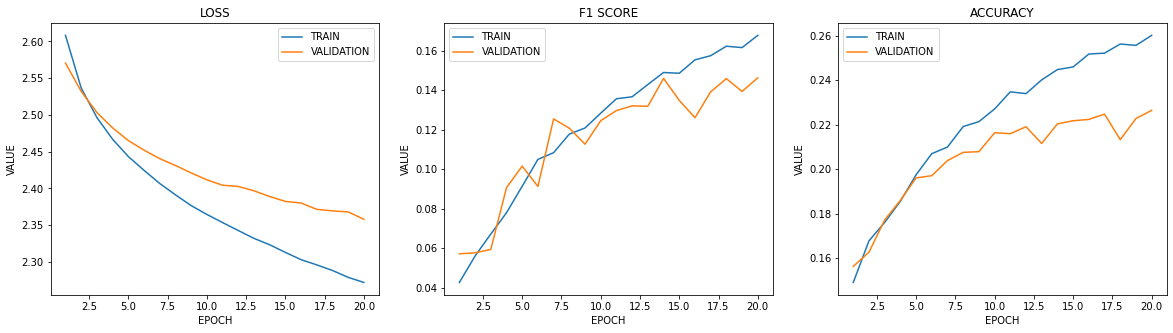


--MODEL--
Layers:  3
Initialization:  random_normal
Optimizer:  Adam
Learning rate:  0.001
Epochs:  20
Batch:  500

Best validation F1Score:  0.0812
Best validation Loss:  2.480299949645996
Best validation Accuracy:  0.1825

Mean epoch time (s):  24.61
Total time (s):  492.22


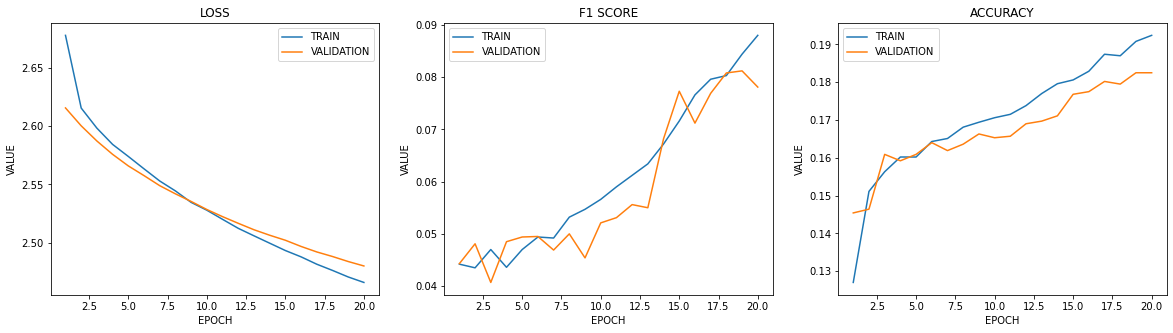


--MODEL--
Layers:  3
Initialization:  random_normal
Optimizer:  Adam
Learning rate:  0.001
Epochs:  40
Batch:  100

Best validation F1Score:  0.1887
Best validation Loss:  2.3134000301361084
Best validation Accuracy:  0.2449

Mean epoch time (s):  37.18
Total time (s):  1487.4


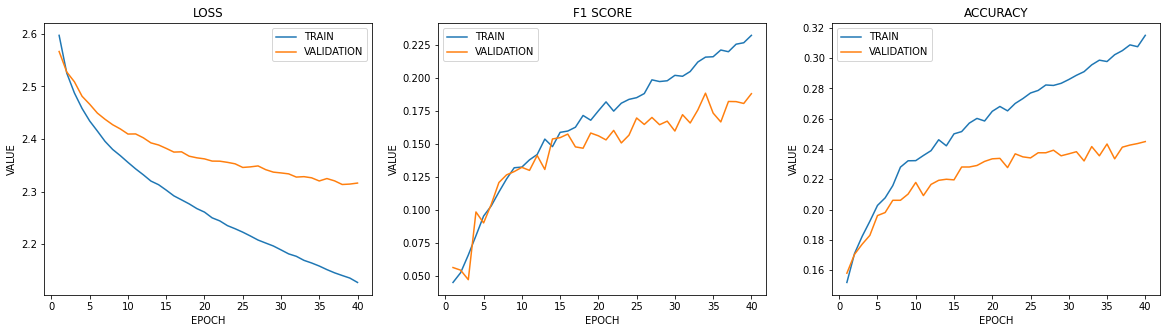


--MODEL--
Layers:  3
Initialization:  random_normal
Optimizer:  Adam
Learning rate:  0.001
Epochs:  40
Batch:  500

Best validation F1Score:  0.128
Best validation Loss:  2.421600103378296
Best validation Accuracy:  0.2146

Mean epoch time (s):  24.89
Total time (s):  995.52


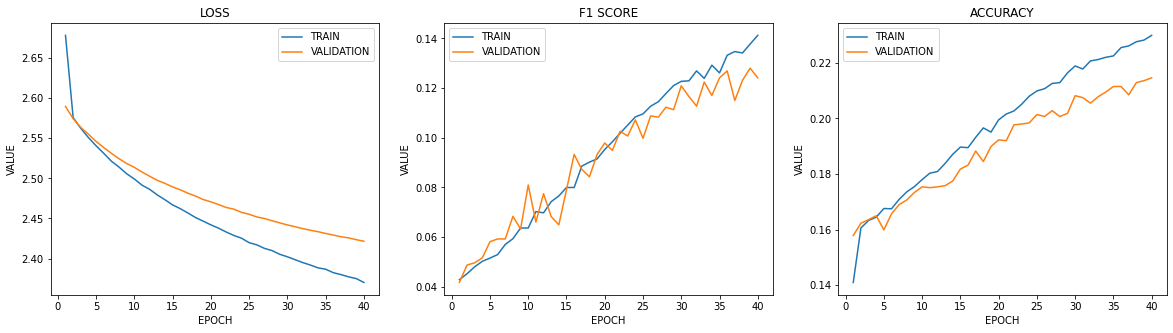


--MODEL--
Layers:  3
Initialization:  random_normal
Optimizer:  Adam
Learning rate:  0.01
Epochs:  20
Batch:  100

Best validation F1Score:  0.2127
Best validation Loss:  2.2841999530792236
Best validation Accuracy:  0.2655

Mean epoch time (s):  37.28
Total time (s):  745.65


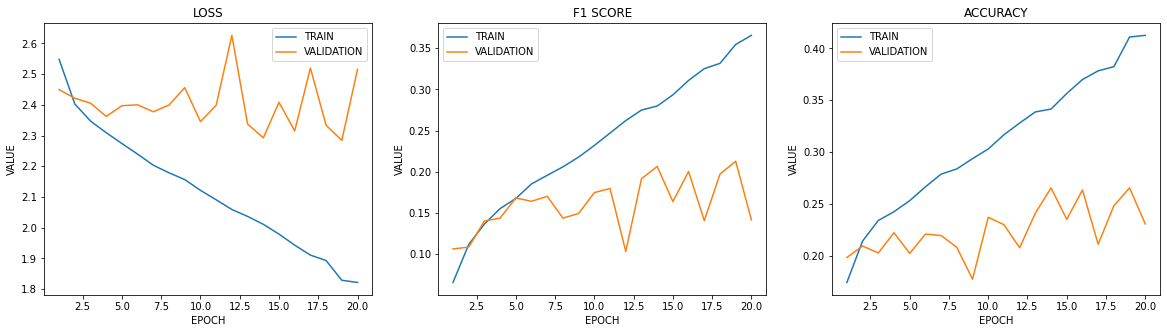


--MODEL--
Layers:  3
Initialization:  random_normal
Optimizer:  Adam
Learning rate:  0.01
Epochs:  20
Batch:  500

Best validation F1Score:  0.1814
Best validation Loss:  2.3396999835968018
Best validation Accuracy:  0.2325

Mean epoch time (s):  24.5
Total time (s):  489.94


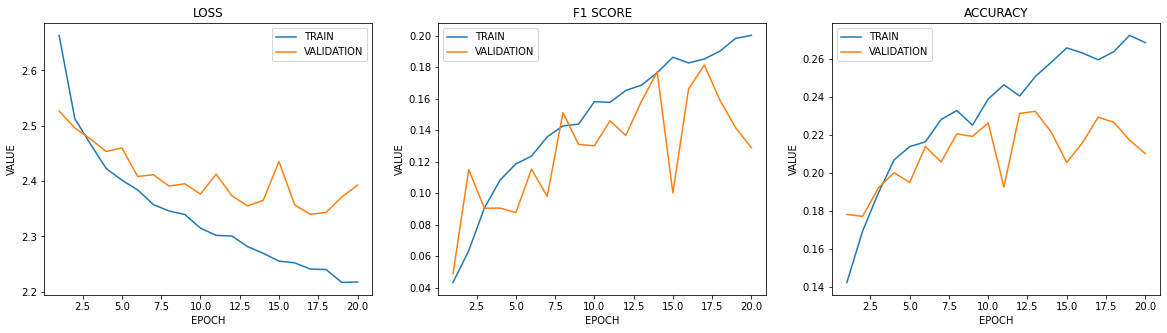


--MODEL--
Layers:  3
Initialization:  random_normal
Optimizer:  Adam
Learning rate:  0.01
Epochs:  40
Batch:  100

Best validation F1Score:  0.2664
Best validation Loss:  2.278899908065796
Best validation Accuracy:  0.2908

Mean epoch time (s):  34.23
Total time (s):  1369.07


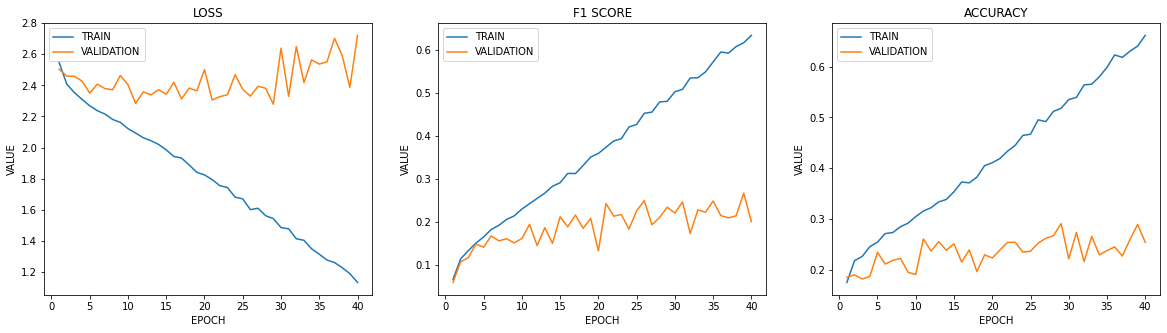


--MODEL--
Layers:  3
Initialization:  random_normal
Optimizer:  Adam
Learning rate:  0.01
Epochs:  40
Batch:  500

Best validation F1Score:  0.2055
Best validation Loss:  2.2987000942230225
Best validation Accuracy:  0.2547

Mean epoch time (s):  21.49
Total time (s):  859.41


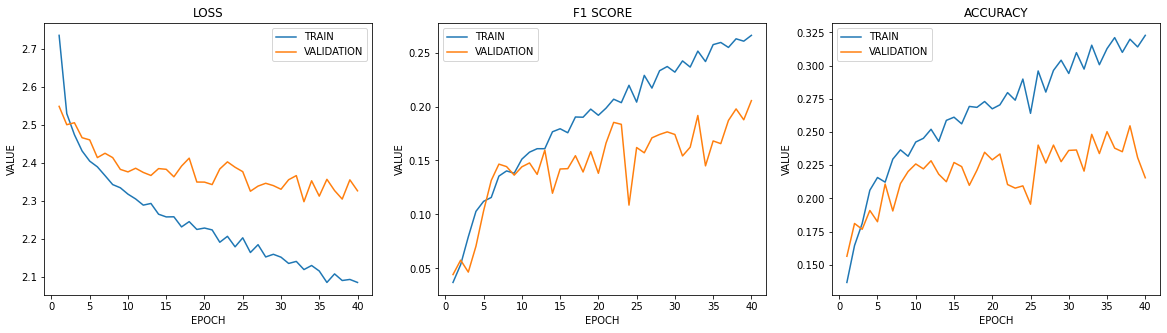


--MODEL--
Layers:  3
Initialization:  random_normal
Optimizer:  SGD
Learning rate:  0.001
Epochs:  20
Batch:  100

Best validation F1Score:  0.1684
Best validation Loss:  2.3536999225616455
Best validation Accuracy:  0.2352

Mean epoch time (s):  33.55
Total time (s):  670.94


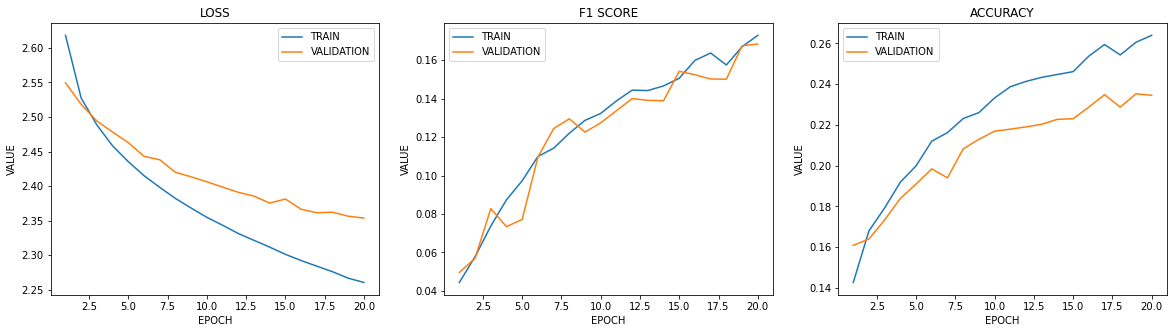


--MODEL--
Layers:  3
Initialization:  random_normal
Optimizer:  SGD
Learning rate:  0.001
Epochs:  20
Batch:  500

Best validation F1Score:  0.0855
Best validation Loss:  2.4774999618530273
Best validation Accuracy:  0.1876

Mean epoch time (s):  21.37
Total time (s):  427.43


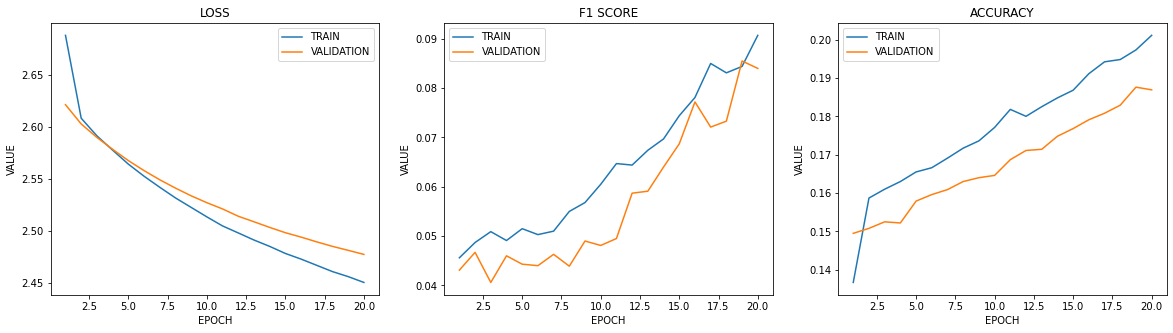


--MODEL--
Layers:  3
Initialization:  random_normal
Optimizer:  SGD
Learning rate:  0.001
Epochs:  40
Batch:  100

Best validation F1Score:  0.1989
Best validation Loss:  2.308300018310547
Best validation Accuracy:  0.2476

Mean epoch time (s):  33.63
Total time (s):  1345.27


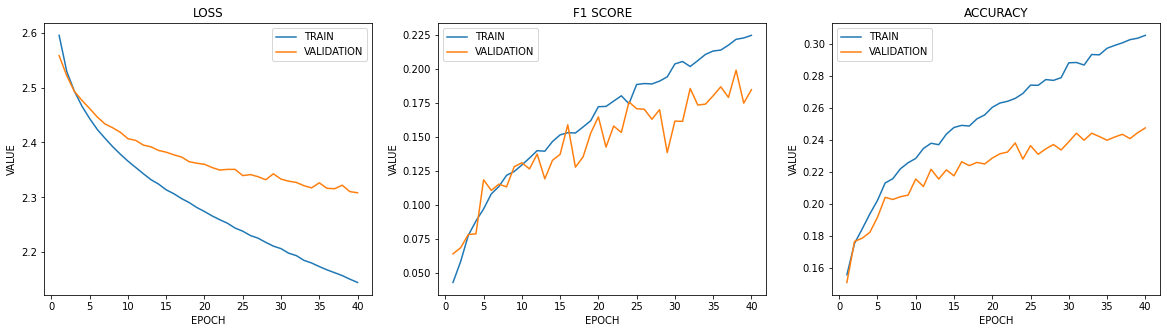


--MODEL--
Layers:  3
Initialization:  random_normal
Optimizer:  SGD
Learning rate:  0.001
Epochs:  40
Batch:  500

Best validation F1Score:  0.1165
Best validation Loss:  2.4291000366210938
Best validation Accuracy:  0.2038

Mean epoch time (s):  22.32
Total time (s):  892.73


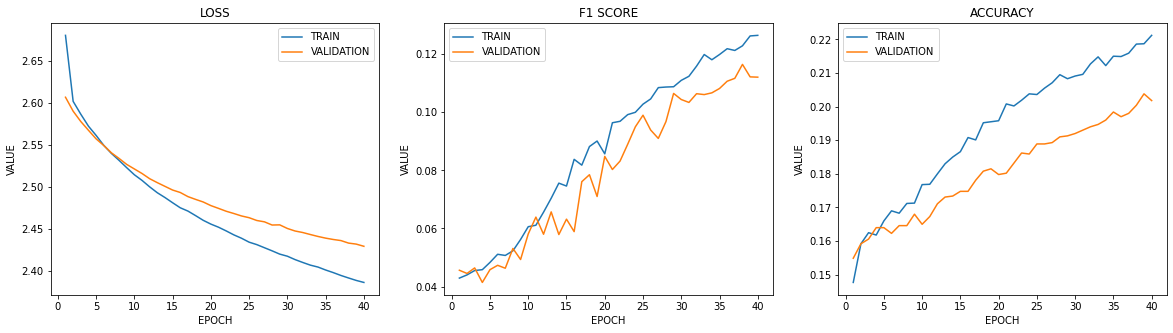


--MODEL--
Layers:  3
Initialization:  random_normal
Optimizer:  SGD
Learning rate:  0.01
Epochs:  20
Batch:  100

Best validation F1Score:  0.2148
Best validation Loss:  2.2852001190185547
Best validation Accuracy:  0.2652

Mean epoch time (s):  34.94
Total time (s):  698.73


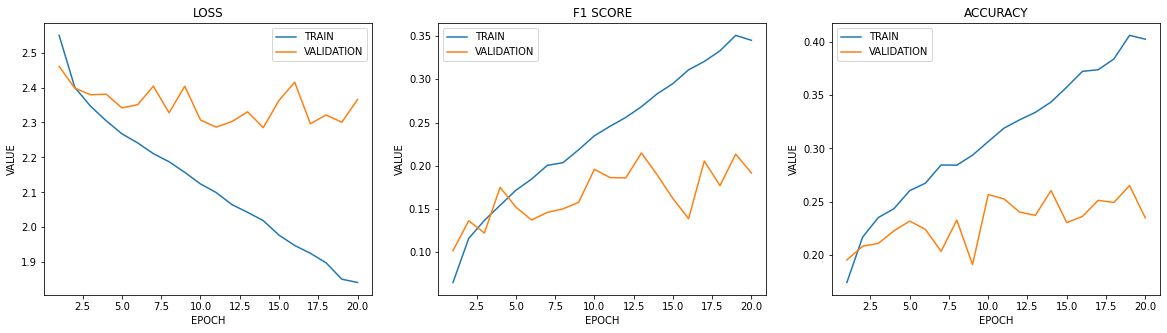


--MODEL--
Layers:  3
Initialization:  random_normal
Optimizer:  SGD
Learning rate:  0.01
Epochs:  20
Batch:  500

Best validation F1Score:  0.1832
Best validation Loss:  2.3232998847961426
Best validation Accuracy:  0.2328

Mean epoch time (s):  22.1
Total time (s):  442.07


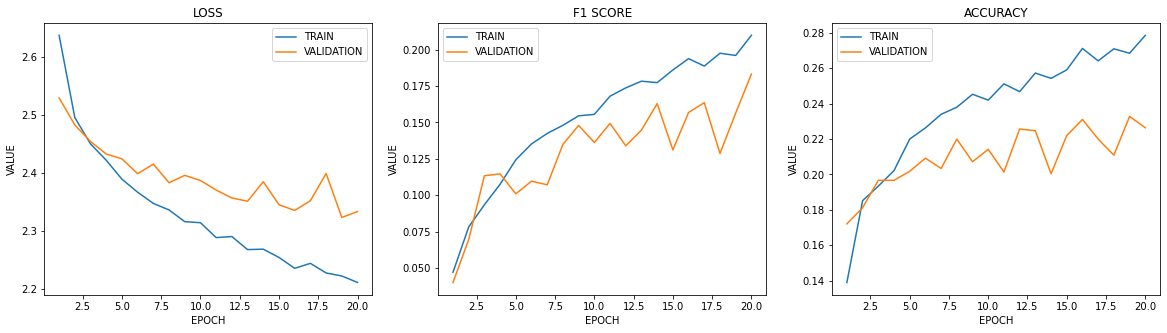


--MODEL--
Layers:  3
Initialization:  random_normal
Optimizer:  SGD
Learning rate:  0.01
Epochs:  40
Batch:  100

Best validation F1Score:  0.2753
Best validation Loss:  2.278700113296509
Best validation Accuracy:  0.2733

Mean epoch time (s):  33.97
Total time (s):  1358.68


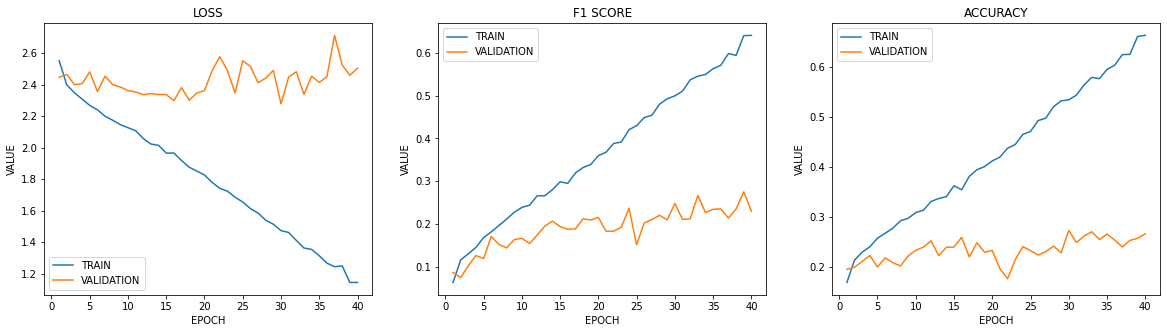


--MODEL--
Layers:  3
Initialization:  random_normal
Optimizer:  SGD
Learning rate:  0.01
Epochs:  40
Batch:  500

Best validation F1Score:  0.1987
Best validation Loss:  2.303800106048584
Best validation Accuracy:  0.247

Mean epoch time (s):  21.44
Total time (s):  857.54


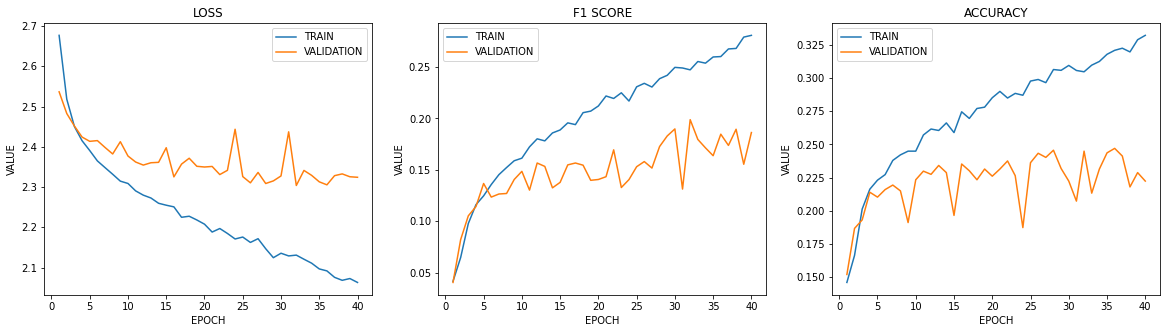

In [26]:
show_experiments_results(results_2)

In [31]:
results_df_2 = results_df_2.sort_values('val_f1', ascending=False)
results_df_2 = results_df_2.reset_index(inplace=False)
results_df_2[
    [
        'layers', 'initialization', 'optimizer', 'lr',
        'epochs', 'batch', 'epoch_num', 'val_loss',
        'val_f1', 'val_acc', 'total_time_s'
    ]
]

,layers,initialization,optimizer,lr,epochs,batch,epoch_num,val_loss,val_f1,val_acc,total_time_s
0,3,random_normal,SGD,0.01,40,100,39,2.4595,0.2753,0.2574,1358.68
1,3,random_normal,Adam,0.01,40,100,39,2.3872,0.2664,0.2891,1369.07
2,3,random_normal,SGD,0.01,20,100,13,2.3306,0.2148,0.2372,698.73
3,3,random_normal,Adam,0.01,20,100,19,2.2842,0.2127,0.2655,745.65
4,3,random_normal,Adam,0.01,40,500,40,2.3274,0.2055,0.2156,859.41
5,3,random_normal,SGD,0.001,40,100,38,2.3221,0.1989,0.2409,1345.27
6,3,random_normal,SGD,0.01,40,500,32,2.3038,0.1987,0.2449,857.54
7,3,random_normal,Adam,0.001,40,100,34,2.3261,0.1887,0.2355,1487.4
8,3,random_normal,SGD,0.01,20,500,20,2.3335,0.1832,0.2264,442.07
9,3,random_normal,Adam,0.01,20,500,17,2.3397,0.1814,0.2294,489.94


In [30]:
results_df_2.to_csv('./task2_results.csv')
#zapisać obydwa jeszcze raz
#i zapisać modele

--MODEL--
Layers:  3
Initialization:  random_normal
Optimizer:  SGD
Learning rate:  0.01
Epochs:  40
Batch:  100

Best validation F1Score:  0.2753
Best validation Loss:  2.278700113296509
Best validation Accuracy:  0.2733

Mean epoch time (s):  33.97
Total time (s):  1358.68


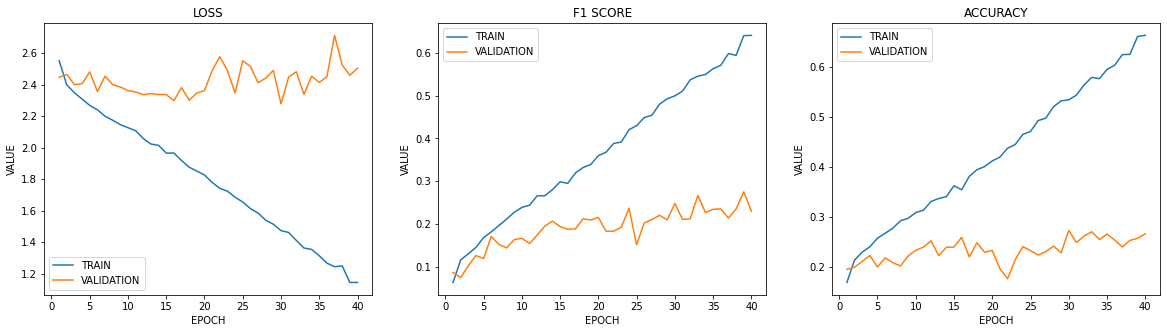

In [32]:
show_experiments_results([results_2[-2]])

### Results

In [33]:
# !lsof -i tcp:6006 | awk 'NR!=1 {print $2}' | xargs kill 
# %tensorboard --host 0.0.0.0 --port 6006 --logdir logs/gradient_tape

In [36]:
model = results_2[-2]['model']

In [37]:
y_true = tf.reshape(test_ds['y'], test_ds['y'].shape[0])
y_pred_probs = model(test_ds['X'])

In [38]:
print('Test F1: '+str(f1_eval(y_true, y_pred_probs)))

Test F1: 0.2436798806771498


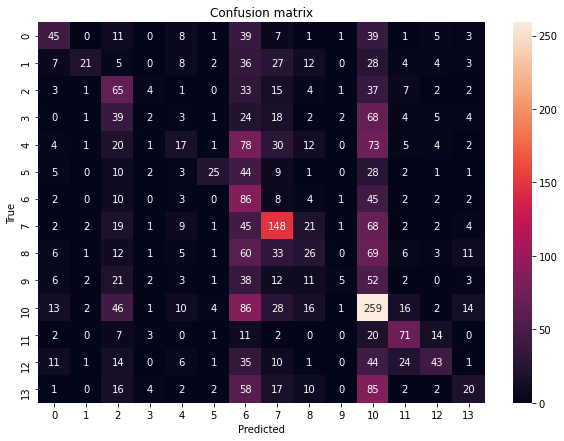

In [39]:
y_pred = tf.math.argmax(y_pred_probs, 1)
y_pred = tf.reshape(y_pred, y_pred.shape[0])

labels = tf.unique(y_true)[0].numpy()
labels.sort()

matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(matrix, index = labels,
                  columns = [i for i in labels])

plt.figure(figsize = (10,7))
plt.title("Confusion matrix")
sn.heatmap(df_cm, annot=True, fmt='g')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

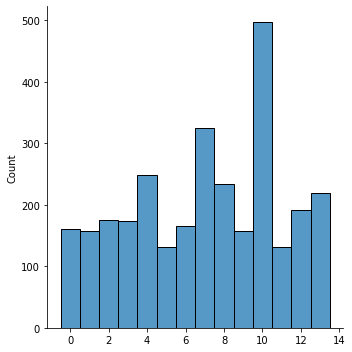

In [21]:
sn.displot(y_true.numpy(), discrete=True)

In [60]:
def get_misclasified(c):
    return [i for i in range(len(y_true.numpy()))
                 if y_true.numpy()[i] != y_pred.numpy()[i] and y_true.numpy()[i] == c]

def get_properclasified(c):
    return [i for i in range(len(y_true.numpy()))
                 if y_true.numpy()[i] == y_pred.numpy()[i] and y_true.numpy()[i] == c]

def plot_misclasified(c):
    fig, axs = plt.subplots(1, 3, figsize=(20,5))
    axs[0].imshow(test_ds['X'][get_misclasified(c)[0]])
    axs[0].title.set_text('TRUE: '+str(y_pred[get_misclasified(c)[0]].numpy())+' | PREDICTED: '+str(c))
    axs[1].imshow(test_ds['X'][get_misclasified(c)[1]])
    axs[1].title.set_text('TRUE: '+str(y_pred[get_misclasified(c)[1]].numpy())+' | PREDICTED: '+str(c))
    axs[2].imshow(test_ds['X'][get_misclasified(c)[2]])
    axs[2].title.set_text('TRUE: '+str(y_pred[get_misclasified(c)[2]].numpy())+' | PREDICTED: '+str(c))
    plt.show()
    
def plot_properclasified(c):
    fig, axs = plt.subplots(1, 3, figsize=(20,5))
    axs[0].imshow(test_ds['X'][get_properclasified(c)[0]])
    axs[0].title.set_text('TRUE: '+str(y_pred[get_properclasified(c)[0]].numpy())+' | PREDICTED: '+str(c))
    axs[1].imshow(test_ds['X'][get_properclasified(c)[1]])
    axs[1].title.set_text('TRUE: '+str(y_pred[get_properclasified(c)[1]].numpy())+' | PREDICTED: '+str(c))
    axs[2].imshow(test_ds['X'][get_properclasified(c)[2]])
    axs[2].title.set_text('TRUE: '+str(y_pred[get_properclasified(c)[2]].numpy())+' | PREDICTED: '+str(c))
    plt.show()

#### Misclasified class = 13

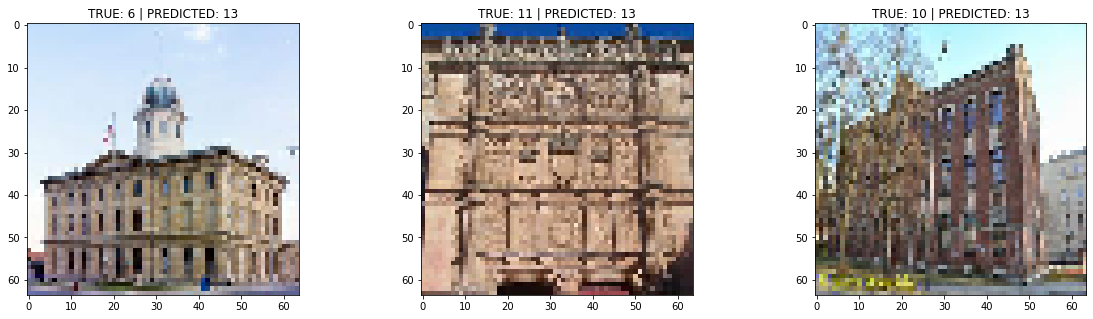

In [61]:
plot_misclasified(13)

#### Misclasified class = 5

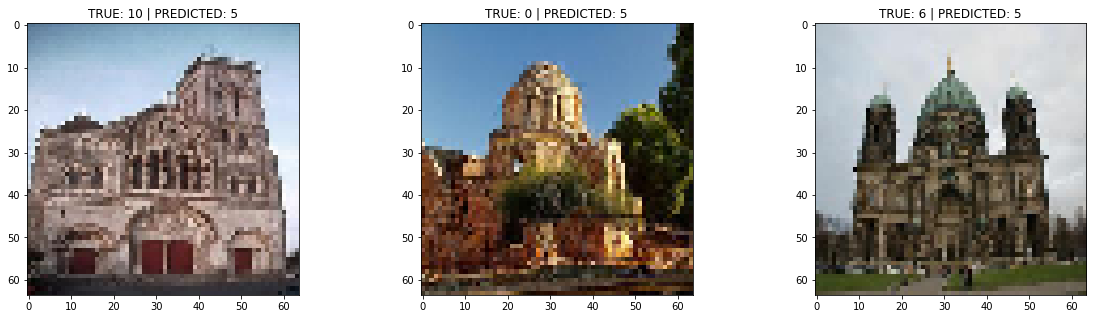

In [62]:
plot_misclasified(5)

#### Properclasified class = 10

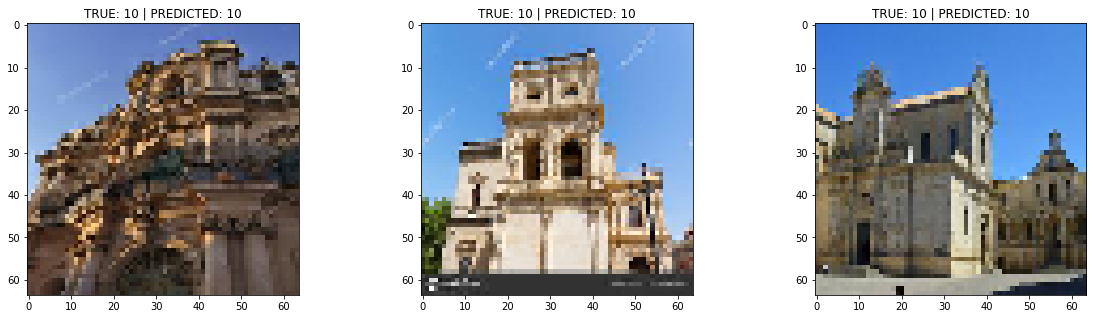

In [63]:
plot_properclasified(10)